# **Part II: Autoencoders for Anomaly Detection**

In [2]:
!pip install torchinfo

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from torchinfo import summary
from torch.utils.data import DataLoader, TensorDataset

## **Step 1: Dataset**

In [358]:
df = pd.read_csv('nyc_taxi.csv')

## **Step 2: Data Exploration and Preprocessing**

In [359]:
df.shape, df.size, df.columns

((10320, 2), 20640, Index(['timestamp', 'value'], dtype='object'))

In [360]:
df.head(5)

,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820


### **Statistics**

In [361]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10320 entries, 0 to 10319
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   timestamp  10320 non-null  object
 1   value      10320 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 161.4+ KB


In [362]:
print(df['value'].median())
df.describe()

16778.0


,value
count,10320.000000
mean,15137.569380
std,6939.495808
min,8.000000
25%,10262.000000
50%,16778.000000
75%,19838.750000
max,39197.000000


### **Null Values, Duplicates, Handling Data**

In [363]:
a = df.isnull().sum()
b = df.duplicated().sum()

print(a,b)

timestamp    0
value        0
dtype: int64 0


In [364]:
df.select_dtypes(include='number').columns

Index(['value'], dtype='object')

In [365]:
sorted(df['value'].unique().tolist())[:5], sorted(df['value'].unique().tolist())[-5:]

([8, 9, 11, 20, 21], [30236, 30313, 30373, 35212, 39197])

In [366]:
df['DateTime'] = pd.to_datetime(df['timestamp'])

print(df['DateTime'].dtype)

datetime64[ns]


In [367]:
df

,timestamp,value,DateTime
0,2014-07-01 00:00:00,10844,2014-07-01 00:00:00
1,2014-07-01 00:30:00,8127,2014-07-01 00:30:00
2,2014-07-01 01:00:00,6210,2014-07-01 01:00:00
3,2014-07-01 01:30:00,4656,2014-07-01 01:30:00
4,2014-07-01 02:00:00,3820,2014-07-01 02:00:00
...,...,...,...
10315,2015-01-31 21:30:00,24670,2015-01-31 21:30:00
10316,2015-01-31 22:00:00,25721,2015-01-31 22:00:00
10317,2015-01-31 22:30:00,27309,2015-01-31 22:30:00
10318,2015-01-31 23:00:00,26591,2015-01-31 23:00:00


### **Visualization Graphs**

Text(0.5, 1.0, 'Boxplot for number of taxi passengers per 30 mins')

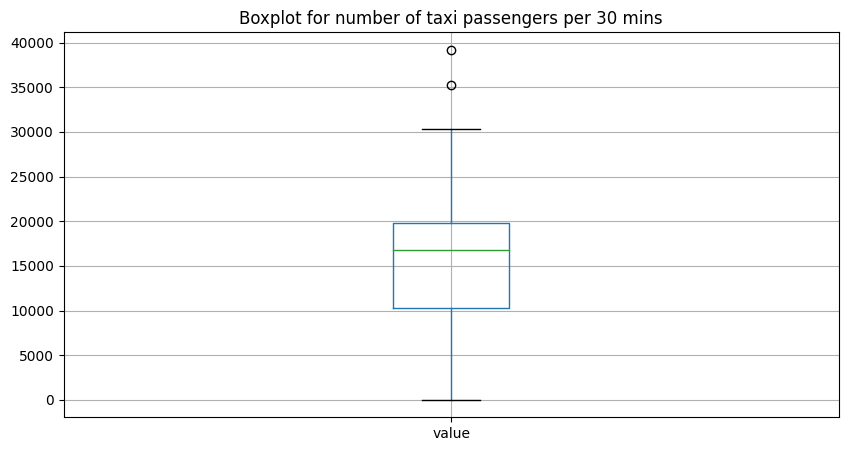

In [368]:
fig, ax = plt.subplots(figsize=(10, 5))
df.boxplot(ax=ax)
plt.title('Boxplot for number of taxi passengers per 30 mins')

<Axes: xlabel='DateTime'>

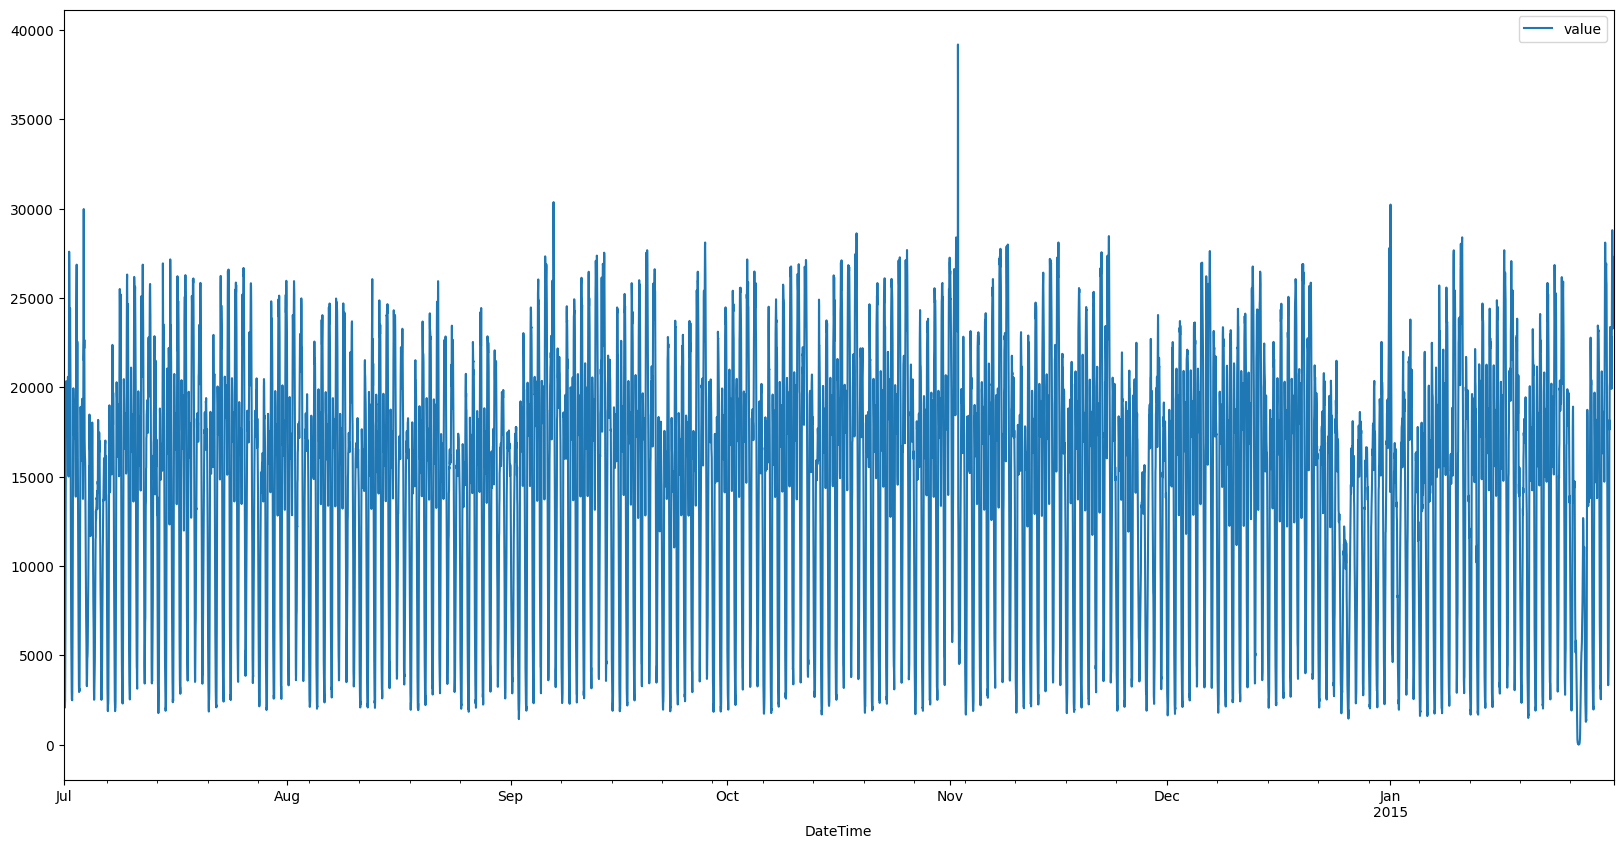

In [369]:
df.set_index('DateTime').plot(figsize=(20, 10))

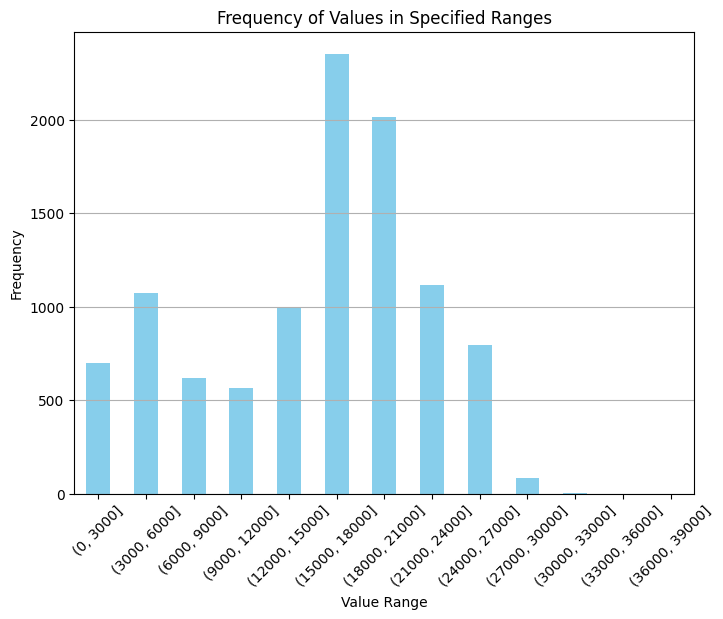

In [370]:
bins = range(0, 40001, 3000)

frequency_counts = pd.cut(df['value'], bins).value_counts().sort_index()
plt.figure(figsize=(8, 6))
frequency_counts.plot(kind='bar', color='skyblue')

plt.xlabel('Value Range')
plt.ylabel('Frequency')
plt.title('Frequency of Values in Specified Ranges')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

### **Feature Engineering and Data Preparation**

In [371]:
min_max_df = df.sort_values(by='value')
min_vals = min_max_df.head(10)
max_vals = min_max_df.tail(10)

print("*" * 20, "Minimum Samples", "*" * 20)
print(min_vals)
print("*" * 20, "Maximum Samples", "*" * 20)
print(max_vals)

******************** Minimum Samples ********************
                 timestamp  value            DateTime
10086  2015-01-27 03:00:00      8 2015-01-27 03:00:00
10088  2015-01-27 04:00:00      9 2015-01-27 04:00:00
10087  2015-01-27 03:30:00     11 2015-01-27 03:30:00
10089  2015-01-27 04:30:00     20 2015-01-27 04:30:00
10090  2015-01-27 05:00:00     21 2015-01-27 05:00:00
10084  2015-01-27 02:00:00     26 2015-01-27 02:00:00
10085  2015-01-27 02:30:00     32 2015-01-27 02:30:00
10091  2015-01-27 05:30:00     37 2015-01-27 05:30:00
10083  2015-01-27 01:30:00     39 2015-01-27 01:30:00
10082  2015-01-27 01:00:00     40 2015-01-27 01:00:00
******************** Maximum Samples ********************
                 timestamp  value            DateTime
6959   2014-11-22 23:30:00  28472 2014-11-22 23:30:00
5279   2014-10-18 23:30:00  28626 2014-10-18 23:30:00
10310  2015-01-31 19:00:00  28804 2015-01-31 19:00:00
8833   2015-01-01 00:30:00  29547 2015-01-01 00:30:00
134    2014-07-03 19

In [372]:
min_max_df

,timestamp,value,DateTime
10086,2015-01-27 03:00:00,8,2015-01-27 03:00:00
10088,2015-01-27 04:00:00,9,2015-01-27 04:00:00
10087,2015-01-27 03:30:00,11,2015-01-27 03:30:00
10089,2015-01-27 04:30:00,20,2015-01-27 04:30:00
10090,2015-01-27 05:00:00,21,2015-01-27 05:00:00
...,...,...,...
8834,2015-01-01 01:00:00,30236,2015-01-01 01:00:00
3261,2014-09-06 22:30:00,30313,2014-09-06 22:30:00
3262,2014-09-06 23:00:00,30373,2014-09-06 23:00:00
5955,2014-11-02 01:30:00,35212,2014-11-02 01:30:00


In [373]:
df['DateTime'].dt.hour

0         0
1         0
2         1
3         1
4         2
         ..
10315    21
10316    22
10317    22
10318    23
10319    23
Name: DateTime, Length: 10320, dtype: int64

In [374]:
# df['Year'] = df['DateTime'].dt.year
df['Month'] = df['DateTime'].dt.month
df['Day'] = df['DateTime'].dt.day
df['DayOfWeek'] = df['DateTime'].dt.dayofweek
df['Hour'] = df['DateTime'].dt.hour
df['Minute'] = df['DateTime'].dt.minute

In [375]:
df.head(3)

,timestamp,value,DateTime,Month,Day,DayOfWeek,Hour,Minute
0,2014-07-01 00:00:00,10844,2014-07-01 00:00:00,7,1,1,0,0
1,2014-07-01 00:30:00,8127,2014-07-01 00:30:00,7,1,1,0,30
2,2014-07-01 01:00:00,6210,2014-07-01 01:00:00,7,1,1,1,0


In [376]:
df_new = df.drop(columns=['timestamp', 'DateTime', 'Month'], inplace=False)

In [377]:
df_new.head(3)

,value,Day,DayOfWeek,Hour,Minute
0,10844,1,1,0,0
1,8127,1,1,0,30
2,6210,1,1,1,0


### **Normalization**

In [378]:
col_list = df_new.columns.tolist()

scaler = MinMaxScaler()
df_new[col_list] = scaler.fit_transform(df_new[col_list])

In [379]:
df_new.head(10)

,value,Day,DayOfWeek,Hour,Minute
0,0.276506,0.0,0.166667,0.000000,0.0
1,0.207175,0.0,0.166667,0.000000,1.0
2,0.158259,0.0,0.166667,0.043478,0.0
3,0.118605,0.0,0.166667,0.043478,1.0
4,0.097272,0.0,0.166667,0.086957,0.0
5,0.073107,0.0,0.166667,0.086957,1.0
6,0.060246,0.0,0.166667,0.130435,0.0
7,0.052464,0.0,0.166667,0.130435,1.0
8,0.056470,0.0,0.166667,0.173913,0.0
9,0.054862,0.0,0.166667,0.173913,1.0


### **Splitting the Data**

In [380]:
X_train_validation, X_test = train_test_split(df_new, test_size=0.15, shuffle=False, random_state=42)
X_train, X_val = train_test_split(X_train_validation, test_size=0.18, shuffle=False, random_state=42)

In [381]:
len(X_train), len(X_val), len(X_test)

(7193, 1579, 1548)

In [382]:
len(X_train.columns), len(X_val.columns), len(X_test.columns)

(5, 5, 5)

In [383]:
train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
test_tensor = torch.tensor(X_test.values, dtype=torch.float32)

In [384]:
train_tensor.shape, val_tensor.shape, test_tensor.shape

(torch.Size([7193, 5]), torch.Size([1579, 5]), torch.Size([1548, 5]))

In [385]:
train_loader = DataLoader(train_tensor, batch_size=64, shuffle=False)
val_loader = DataLoader(val_tensor, batch_size=64, shuffle=False)
test_loader = DataLoader(test_tensor, batch_size=64, shuffle=False)

In [386]:
# for inputs in train_loader:
#   print(inputs)
#   break

In [387]:
X_train.shape

(7193, 5)

In [389]:
min_max_test = X_test.sort_values(by='value')
min_vals_test = min_max_test.head(30).index
max_vals_test = min_max_test.tail(30).index

print(min_vals_test)
print(max_vals_test)

Int64Index([10086, 10088, 10087, 10089, 10090, 10084, 10085, 10091, 10083,
            10082, 10092, 10081, 10093, 10080, 10079, 10094, 10078, 10095,
            10096, 10077, 10097, 10135, 10134, 10137, 10136,  9751,  9750,
            10098,  9079,  9030],
           dtype='int64')
Int64Index([ 9312, 10268,  8825,  9303,  9926, 10269,  9301, 10270,  9638,
            10309, 10262, 10264, 10317,  8827,  9254,  9590,  9309,  9255,
             9591, 10311,  8826,  9304,  9302, 10263,  9310,  8835,  9311,
            10310,  8833,  8834],
           dtype='int64')


## **Step 3: Autoencoder Model Building**

### **Architecture 1**

In [390]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(AutoEncoder, self).__init__()

        # Encoder layers
        self.encoder_fc1 = nn.Linear(input_dim, 64)
        self.encoder_fc2 = nn.Linear(64, 32)
        self.encoder_fc3 = nn.Linear(32, hidden_dim)

        # Decoder layers
        self.decoder_fc1 = nn.Linear(hidden_dim, 32)
        self.decoder_fc2 = nn.Linear(32, 64)
        self.decoder_fc3 = nn.Linear(64, input_dim)
        self.decoder_outputactivation = nn.Sigmoid()

        self.activation = nn.ReLU()

    def forward(self, x):
        # Encoder block
        x = self.activation(self.encoder_fc1(x))
        x = self.activation(self.encoder_fc2(x))
        z = self.encoder_fc3(x)

        # Decoder block
        x = self.activation(self.decoder_fc1(z))
        x = self.activation(self.decoder_fc2(x))
        x = self.decoder_fc3(x)
        x_pred = self.decoder_outputactivation(x)
        return x_pred

In [442]:
model = AutoEncoder(input_dim = X_train.shape[1], hidden_dim = 2)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

In [443]:
print(model)
print(summary(model, input_size=X_train.shape))

AutoEncoder(
  (encoder_fc1): Linear(in_features=5, out_features=64, bias=True)
  (encoder_fc2): Linear(in_features=64, out_features=32, bias=True)
  (encoder_fc3): Linear(in_features=32, out_features=2, bias=True)
  (decoder_fc1): Linear(in_features=2, out_features=32, bias=True)
  (decoder_fc2): Linear(in_features=32, out_features=64, bias=True)
  (decoder_fc3): Linear(in_features=64, out_features=5, bias=True)
  (decoder_outputactivation): Sigmoid()
  (activation): ReLU()
)
Layer (type:depth-idx)                   Output Shape              Param #
AutoEncoder                              [7193, 5]                 --
├─Linear: 1-1                            [7193, 64]                384
├─ReLU: 1-2                              [7193, 64]                --
├─Linear: 1-3                            [7193, 32]                2,080
├─ReLU: 1-4                              [7193, 32]                --
├─Linear: 1-5                            [7193, 2]                 66
├─Linear: 1-6      

In [444]:
training_losses, validation_losses, test_losses = [], [], []
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_reconstruction_errors = []
    criterion = nn.MSELoss()
    for inputs in train_loader:
        optimizer.zero_grad()
        inputs = inputs.float()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()  #* inputs.size(0)
        # print(torch.mean((outputs - inputs)**2, dim=1).detach().numpy().size)
        # print(outputs)
        # print("#"*20)
        # print(inputs)
        train_reconstruction_errors.extend(torch.mean((outputs - inputs)**2, dim=1).detach().numpy())
    train_loss /= len(train_loader.dataset)
    training_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs in val_loader:
            inputs = inputs.float()
            outputs = model(inputs)
            val_loss += criterion(outputs, inputs).item()
    val_loss /= len(val_loader.dataset)
    validation_losses.append(val_loss)

    test_reconstruction_errors = []
    model.eval()
    test_loss = 0.0
    # criterion = nn.MSELoss(reduction='none')
    with torch.no_grad():
        for inputs in test_loader:
            inputs = inputs.float()
            outputs = model(inputs)
            test_loss += criterion(outputs, inputs).item()
            test_reconstruction_errors.extend(torch.mean((outputs - inputs)**2, dim=1).detach().numpy())

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}, Test Loss: {test_loss}')

Epoch 1/10, Train Loss: 0.0012222244314270359, Validation Loss: 0.0009210806616013981, Test Loss: 0.0009384988765027711
Epoch 2/10, Train Loss: 0.0007230193216556155, Validation Loss: 0.0005449692838417721, Test Loss: 0.0005475791596545229
Epoch 3/10, Train Loss: 0.00043300367754155243, Validation Loss: 0.00042043266047625094, Test Loss: 0.0004306170158088207
Epoch 4/10, Train Loss: 0.0003789488521251653, Validation Loss: 0.0003964968292282079, Test Loss: 0.0004145224038415254
Epoch 5/10, Train Loss: 0.0003510988604867266, Validation Loss: 0.0003785549222413236, Test Loss: 0.00040035874860178323
Epoch 6/10, Train Loss: 0.0003405800704252201, Validation Loss: 0.00037365564999794037, Test Loss: 0.0003961687745136577
Epoch 7/10, Train Loss: 0.0003542322447609188, Validation Loss: 0.00037884949915880186, Test Loss: 0.00040348559044643234
Epoch 8/10, Train Loss: 0.00033597722943809027, Validation Loss: 0.0003668821575751197, Test Loss: 0.0003890882643873416
Epoch 9/10, Train Loss: 0.0003378

In [445]:
def plot_loss(training_losses, validation_losses, test_losses):
    plt.plot(list(range(1, len(training_losses) + 1)), training_losses, label='Training Losses')
    plt.plot(list(range(1, len(validation_losses) + 1)), validation_losses, label='Validation Losses')
    plt.plot(list(range(1, len(test_losses) + 1)), test_losses, label='Test Losses')
    plt.xlabel('Number of Epochs')
    plt.ylabel('Loss Value')
    plt.title('Loss v/s Number of Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

#### **Loss Graph**

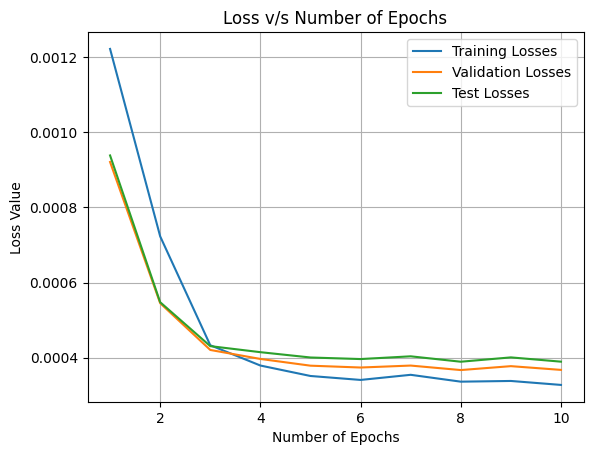

In [446]:
plot_loss(training_losses, validation_losses, test_losses)

In [447]:
len(train_reconstruction_errors), len(test_reconstruction_errors)

(7193, 1548)

In [448]:
train_reconstruction_errors

[0.057853233,
 0.04666057,
 0.050882023,
 0.04132968,
 0.049545057,
 0.04087686,
 0.050336234,
 0.04259868,
 0.05225415,
 0.045559827,
 0.05483664,
 0.04947892,
 0.05864529,
 0.05639761,
 0.0618483,
 0.06079939,
 0.061915655,
 0.06281111,
 0.06403227,
 0.062113784,
 0.06309111,
 0.06030502,
 0.060959034,
 0.06012706,
 0.06189981,
 0.059645467,
 0.06078996,
 0.05959673,
 0.06032149,
 0.06056974,
 0.05877471,
 0.05844596,
 0.058252174,
 0.058489628,
 0.055953253,
 0.05569453,
 0.050955117,
 0.0544855,
 0.049233086,
 0.04946284,
 0.045956023,
 0.04811924,
 0.04400268,
 0.04479868,
 0.042748183,
 0.044422302,
 0.04463097,
 0.051446818,
 0.052703835,
 0.041556533,
 0.04300507,
 0.03506458,
 0.040823888,
 0.033775784,
 0.041157886,
 0.03498202,
 0.042907674,
 0.037730075,
 0.045332678,
 0.041552268,
 0.050216146,
 0.047399342,
 0.05145847,
 0.049831558,
 0.05625401,
 0.051196586,
 0.0565219,
 0.050096266,
 0.053105485,
 0.04942083,
 0.05271216,
 0.049230695,
 0.05306965,
 0.04912352,
 0.0519

#### **Reconstruction Error Distribution Graph**

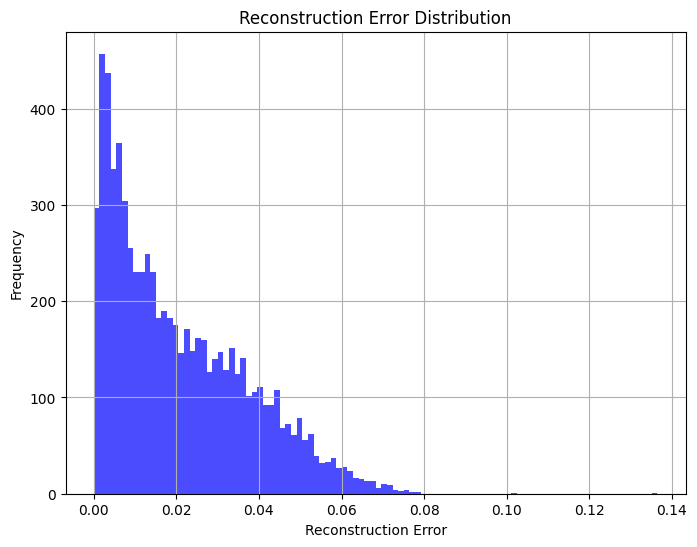

In [489]:
plt.figure(figsize=(8, 6))
plt.hist(train_reconstruction_errors, bins=100, color='blue', alpha=0.7)
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Reconstruction Error Distribution')
plt.grid(True)
plt.show()

In [490]:
mean, std = np.mean(train_reconstruction_errors), np.std(train_reconstruction_errors)

print(f"Mean: {mean}, Standard Deviation: {std}")

Mean: 0.020752819254994392, Standard Deviation: 0.01665569096803665


In [491]:
# Accounting for 95% of data
anomaly_cutoff = mean + (2 * std)
anomaly_cutoff

0.054064201191067696

In [496]:
train_anomalies_detected = X_train[train_reconstruction_errors > anomaly_cutoff]

In [497]:
train_anomalies_detected

,value,Day,DayOfWeek,Hour,Minute
0,0.276506,0.000000,0.166667,0.000000,0.0
10,0.063972,0.000000,0.166667,0.217391,0.0
12,0.166322,0.000000,0.166667,0.260870,0.0
13,0.281482,0.000000,0.166667,0.260870,1.0
14,0.353390,0.000000,0.166667,0.304348,0.0
...,...,...,...,...,...
6020,0.408278,0.066667,0.000000,0.434783,0.0
6021,0.417745,0.066667,0.000000,0.434783,1.0
6022,0.391513,0.066667,0.000000,0.478261,0.0
6023,0.427722,0.066667,0.000000,0.478261,1.0


In [498]:
len(train_anomalies_detected.index)

298

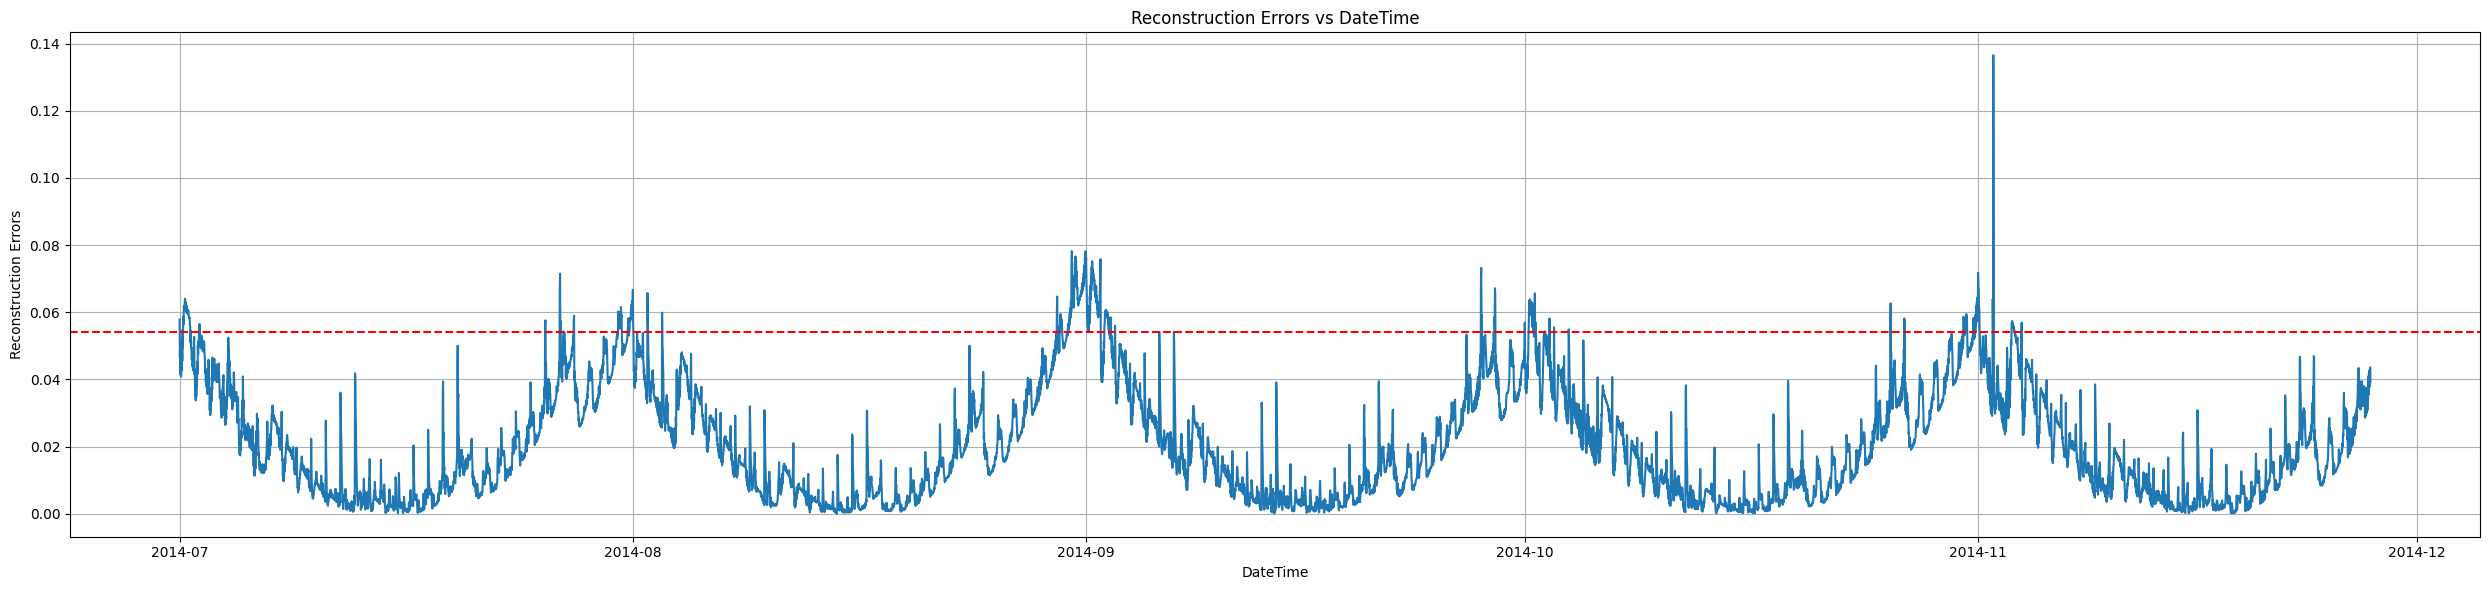

In [501]:
plt.figure(figsize=(25, 6))
plt.plot(df['DateTime'][:7193], train_reconstruction_errors)
plt.axhline(y=anomaly_cutoff, color='red', linestyle='--', label='Anomaly Cutoff')

plt.xlabel('DateTime')
plt.ylabel('Reconstruction Errors')
plt.title('Reconstruction Errors vs DateTime')
plt.grid(True)
plt.tight_layout()
plt.show()

In [440]:
# anomaly_datetimes = df.loc[anomalies_detected.index, 'DateTime']
# anomaly_datetimes.tolist()

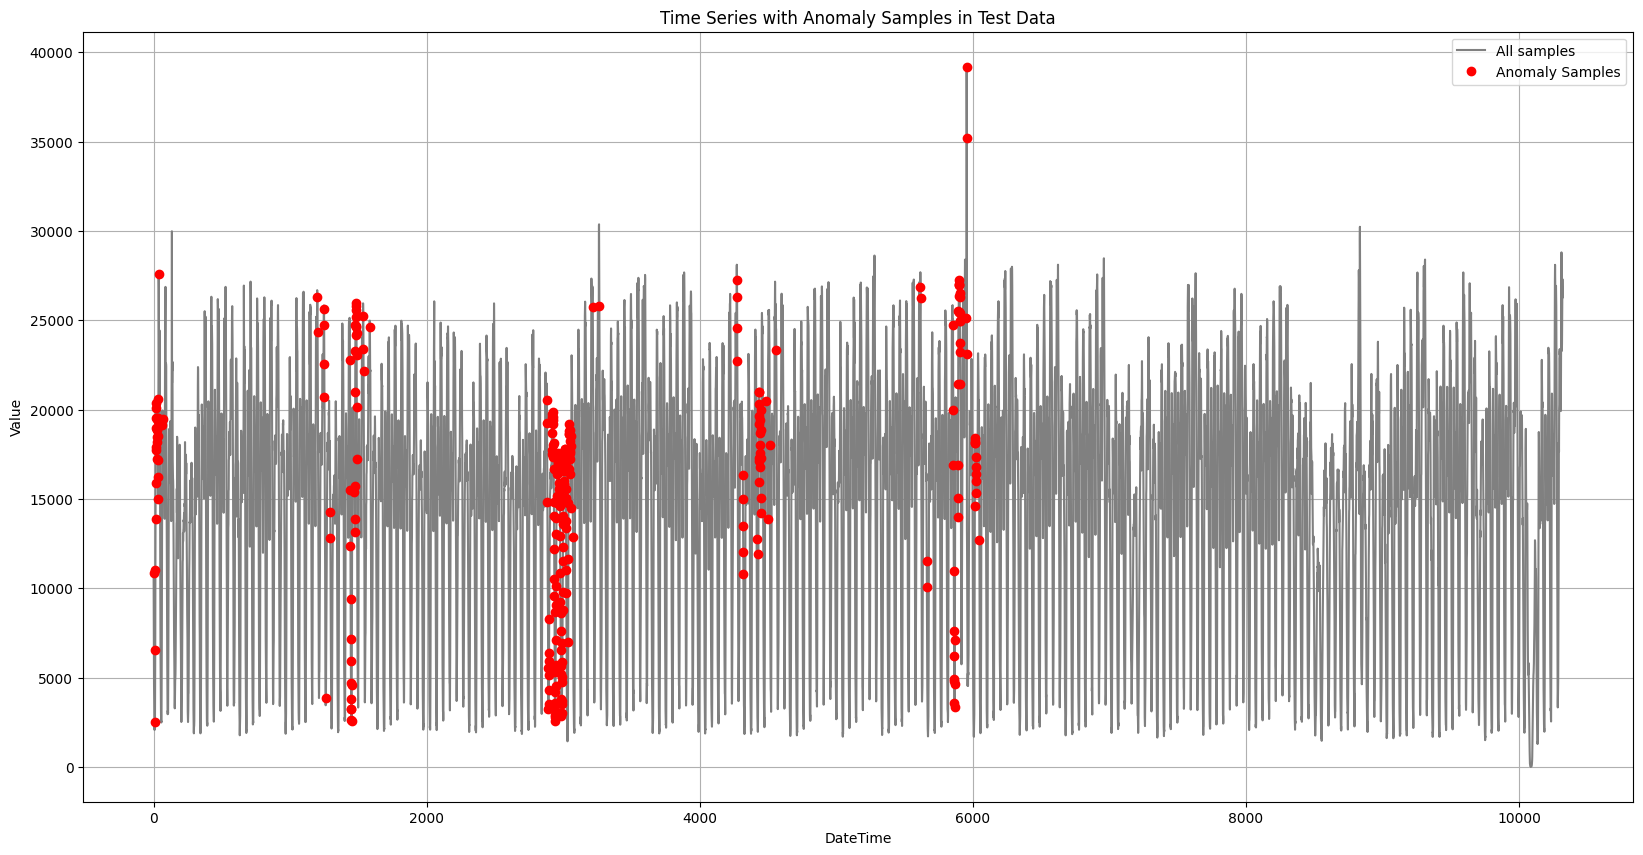

In [502]:
df['value'].plot(figsize=(20, 10), color='gray', label='All samples')
df.loc[train_anomalies_detected.index, 'value'].plot(color='red', label='Anomaly Samples', marker = 'o', linestyle='None')

plt.xlabel('DateTime')
plt.ylabel('Value')
plt.title('Time Series with Anomaly Samples in Test Data')
plt.legend()
plt.grid(True)
plt.show()

In [503]:
anomaly_dates = {}

for i in train_anomalies_detected.index:
    if df.iloc[i]['DateTime'].date() in anomaly_dates:
        anomaly_dates[df.iloc[i]['DateTime'].date()] += 1
    else:
        # print(df.iloc[i]['DateTime'].date())
        anomaly_dates[df.iloc[i]['DateTime'].date()] = 1

In [504]:
anomaly_dates_order = dict(sorted(anomaly_dates.items(), key=lambda k: k[1], reverse=True))
anomaly_dates_order

{datetime.date(2014, 8, 31): 48,
 datetime.date(2014, 9, 1): 48,
 datetime.date(2014, 7, 31): 28,
 datetime.date(2014, 7, 1): 27,
 datetime.date(2014, 10, 31): 25,
 datetime.date(2014, 8, 30): 22,
 datetime.date(2014, 10, 1): 21,
 datetime.date(2014, 9, 2): 20,
 datetime.date(2014, 11, 3): 11,
 datetime.date(2014, 9, 28): 9,
 datetime.date(2014, 7, 27): 7,
 datetime.date(2014, 11, 1): 6,
 datetime.date(2014, 10, 26): 4,
 datetime.date(2014, 11, 2): 4,
 datetime.date(2014, 8, 2): 3,
 datetime.date(2014, 7, 2): 2,
 datetime.date(2014, 7, 26): 2,
 datetime.date(2014, 8, 1): 2,
 datetime.date(2014, 10, 2): 2,
 datetime.date(2014, 7, 30): 1,
 datetime.date(2014, 8, 3): 1,
 datetime.date(2014, 9, 6): 1,
 datetime.date(2014, 9, 7): 1,
 datetime.date(2014, 10, 3): 1,
 datetime.date(2014, 10, 4): 1,
 datetime.date(2014, 10, 30): 1}

In [506]:
anomalies_detected_test = X_test[test_reconstruction_errors > anomaly_cutoff]

In [509]:
len(anomalies_detected_test.index)

109

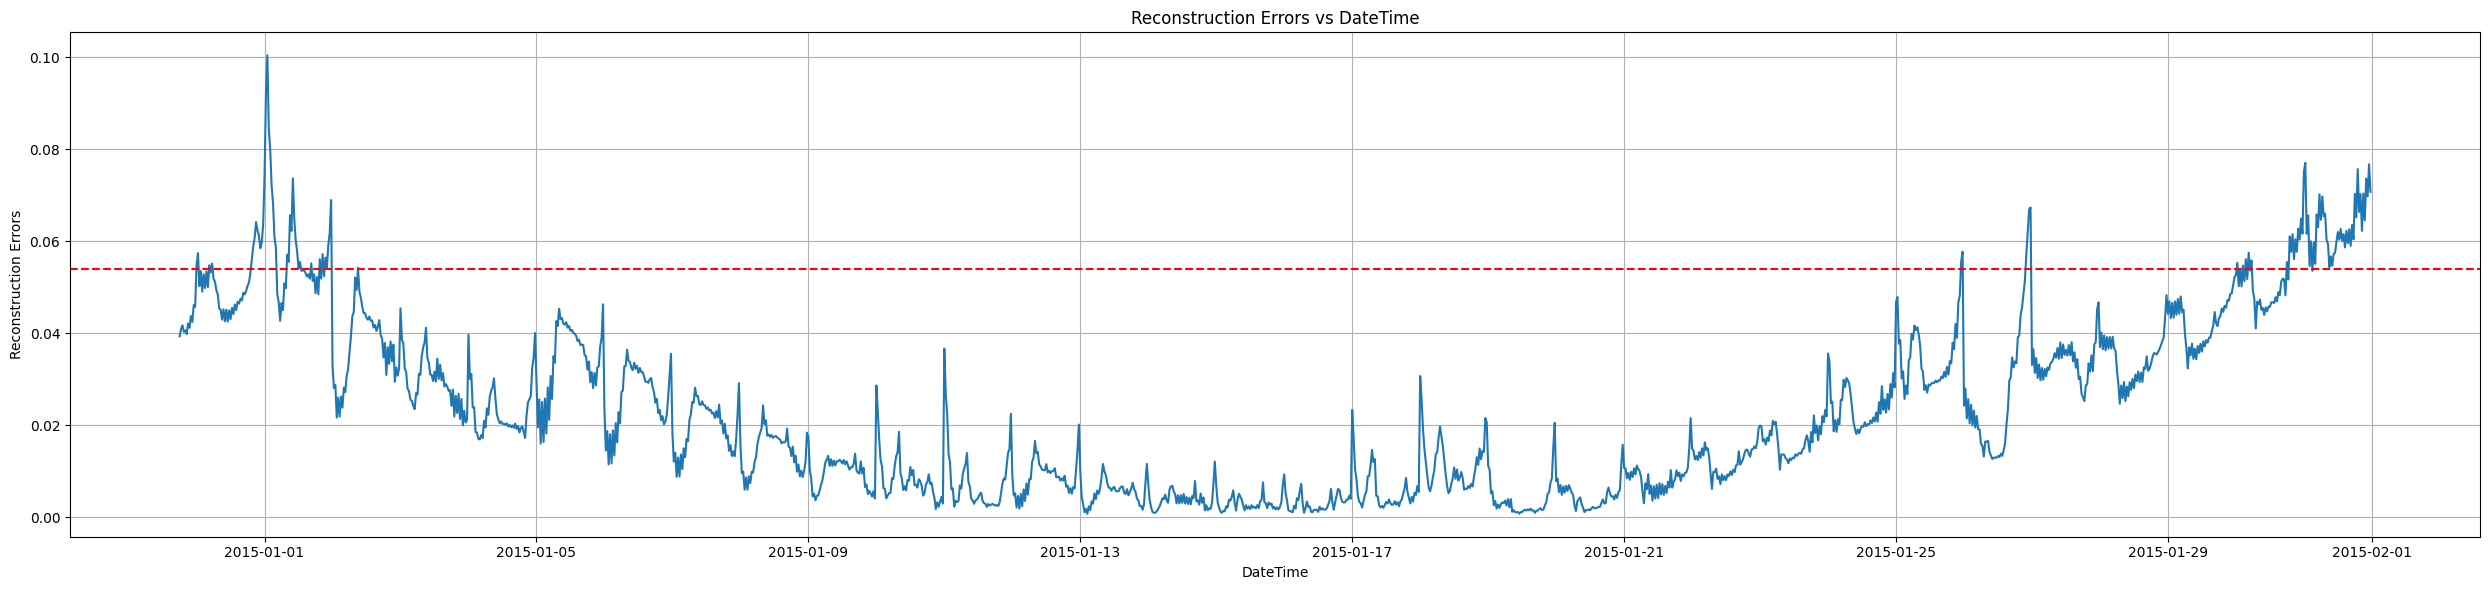

In [510]:
plt.figure(figsize=(25, 6))
plt.plot(df['DateTime'][-1548:], test_reconstruction_errors)
plt.axhline(y=anomaly_cutoff, color='red', linestyle='--', label='Anomaly Cutoff')
plt.xlabel('DateTime')
plt.ylabel('Reconstruction Errors')
plt.title('Reconstruction Errors vs DateTime')
plt.grid(True)
plt.tight_layout()
plt.show()

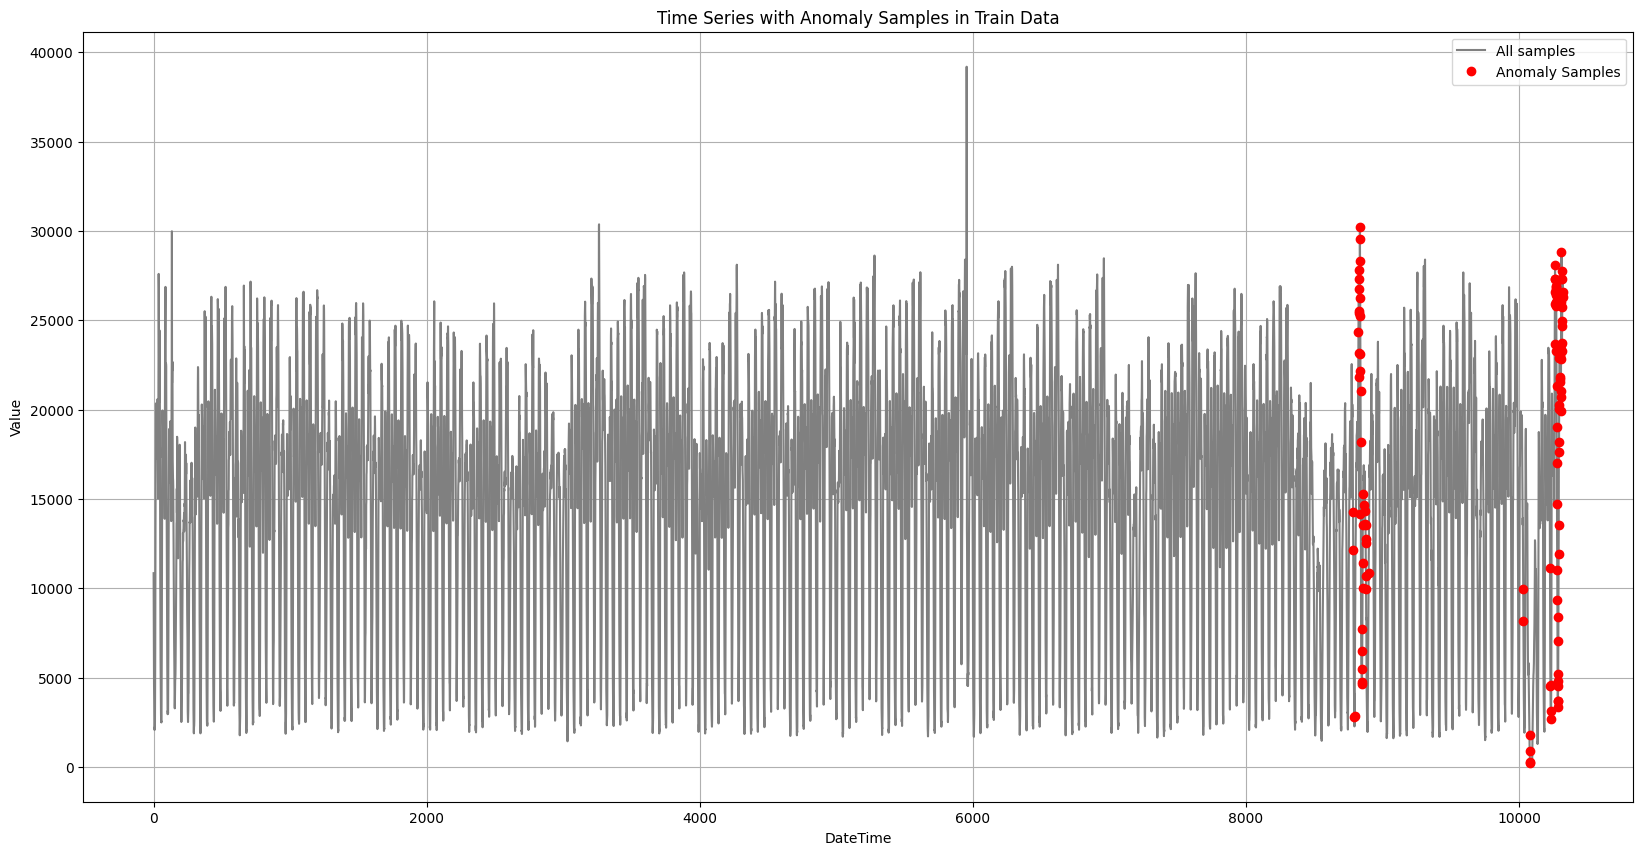

In [511]:
df['value'].plot(x=df['DateTime'], figsize=(20, 10), color='gray', label='All samples')
df.loc[anomalies_detected_test.index, 'value'].plot(color='red', label='Anomaly Samples', marker = 'o',  linestyle='None')

plt.xlabel('DateTime')
plt.ylabel('Value')
plt.title('Time Series with Anomaly Samples in Train Data')
plt.legend()
plt.grid(True)
plt.show()

In [512]:
anomaly_dates_test = {}

for i in anomalies_detected_test.index:
    if df.iloc[i]['DateTime'].date() in anomaly_dates_test:
        anomaly_dates_test[df.iloc[i]['DateTime'].date()] += 1
    else:
        # print(df.iloc[i]['DateTime'].date())
        anomaly_dates_test[df.iloc[i]['DateTime'].date()] = 1

In [513]:
anomaly_dates_order = dict(sorted(anomaly_dates_test.items(), key=lambda k: k[1], reverse=True))
anomaly_dates_order

{datetime.date(2015, 1, 31): 47,
 datetime.date(2015, 1, 1): 26,
 datetime.date(2015, 1, 30): 16,
 datetime.date(2014, 12, 31): 13,
 datetime.date(2015, 1, 26): 4,
 datetime.date(2015, 1, 25): 2,
 datetime.date(2015, 1, 2): 1}

### **Architecture 2**

In [517]:
class AutoEncoder2(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(AutoEncoder2, self).__init__()

        # Encoder layers
        self.encoder_fc1 = nn.Linear(input_dim, 64)
        self.encoder_fc2 = nn.Linear(64, 32)
        self.encoder_fc3 = nn.Linear(32, 16)
        self.encoder_fc4 = nn.Linear(16, hidden_dim)

        # Decoder layers
        self.decoder_fc1 = nn.Linear(hidden_dim, 16)
        self.decoder_fc2 = nn.Linear(16, 32)
        self.decoder_fc3 = nn.Linear(32, 64)
        self.decoder_fc4 = nn.Linear(64, input_dim)
        self.decoder_outputactivation = nn.Sigmoid()

        self.activation = nn.ReLU()

    def forward(self, x):
        # Encoder block
        x = self.activation(self.encoder_fc1(x))
        x = self.activation(self.encoder_fc2(x))
        x = self.activation(self.encoder_fc3(x))
        z = self.encoder_fc4(x)

        # Decoder block
        x = self.activation(self.decoder_fc1(z))
        x = self.activation(self.decoder_fc2(x))
        x = self.activation(self.decoder_fc3(x))
        x = self.decoder_fc4(x)
        x_pred = self.decoder_outputactivation(x)
        return x_pred

In [522]:
model2 = AutoEncoder2(input_dim = X_train.shape[1], hidden_dim = 2)
criterion = nn.MSELoss()
optimizer = optim.Adam(model2.parameters(), lr=0.005)

In [523]:
print(model2)
print(summary(model2, input_size=X_train.shape))

AutoEncoder2(
  (encoder_fc1): Linear(in_features=5, out_features=64, bias=True)
  (encoder_fc2): Linear(in_features=64, out_features=32, bias=True)
  (encoder_fc3): Linear(in_features=32, out_features=16, bias=True)
  (encoder_fc4): Linear(in_features=16, out_features=2, bias=True)
  (decoder_fc1): Linear(in_features=2, out_features=16, bias=True)
  (decoder_fc2): Linear(in_features=16, out_features=32, bias=True)
  (decoder_fc3): Linear(in_features=32, out_features=64, bias=True)
  (decoder_fc4): Linear(in_features=64, out_features=5, bias=True)
  (decoder_outputactivation): Sigmoid()
  (activation): ReLU()
)
Layer (type:depth-idx)                   Output Shape              Param #
AutoEncoder2                             [7193, 5]                 --
├─Linear: 1-1                            [7193, 64]                384
├─ReLU: 1-2                              [7193, 64]                --
├─Linear: 1-3                            [7193, 32]                2,080
├─ReLU: 1-4           

In [524]:
training_losses, validation_losses, test_losses = [], [], []
num_epochs = 10

for epoch in range(num_epochs):
    model2.train()
    train_loss = 0.0
    train_reconstruction_errors = []
    criterion = nn.MSELoss()
    for inputs in train_loader:
        optimizer.zero_grad()
        inputs = inputs.float()
        outputs = model2(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_reconstruction_errors.extend(torch.mean((outputs - inputs)**2, dim=1).detach().numpy())
    train_loss /= len(train_loader.dataset)
    training_losses.append(train_loss)

    # Validation
    model2.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs in val_loader:
            inputs = inputs.float()
            outputs = model2(inputs)
            val_loss += criterion(outputs, inputs).item()
    val_loss /= len(val_loader.dataset)
    validation_losses.append(val_loss)

    test_reconstruction_errors = []
    model2.eval()
    test_loss = 0.0
    # criterion = nn.MSELoss(reduction='none')
    with torch.no_grad():
        for inputs in test_loader:
            inputs = inputs.float()
            outputs = model2(inputs)
            test_loss += criterion(outputs, inputs).item()
            test_reconstruction_errors.extend(torch.mean((outputs - inputs)**2, dim=1).detach().numpy())

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}, Test Loss: {test_loss}')

Epoch 1/10, Train Loss: 0.0013678450744361386, Validation Loss: 0.0010011287286943692, Test Loss: 0.0010136339695551444
Epoch 2/10, Train Loss: 0.0008323813299043162, Validation Loss: 0.0007367318795735584, Test Loss: 0.0007256795020499664
Epoch 3/10, Train Loss: 0.0006937455787558674, Validation Loss: 0.000724393099386002, Test Loss: 0.0007185220811034743
Epoch 4/10, Train Loss: 0.0006775289288275674, Validation Loss: 0.0007002816327326731, Test Loss: 0.0006975555083731271
Epoch 5/10, Train Loss: 0.0006497991839070305, Validation Loss: 0.0006776711725977269, Test Loss: 0.0006773696772547232
Epoch 6/10, Train Loss: 0.0006258107934664506, Validation Loss: 0.0006460262385230603, Test Loss: 0.0006529276764010698
Epoch 7/10, Train Loss: 0.000556354010282153, Validation Loss: 0.0005068523335100126, Test Loss: 0.0005343635082220808
Epoch 8/10, Train Loss: 0.0004470453476027042, Validation Loss: 0.00041671677762695586, Test Loss: 0.00046255064824985906
Epoch 9/10, Train Loss: 0.00039154668925

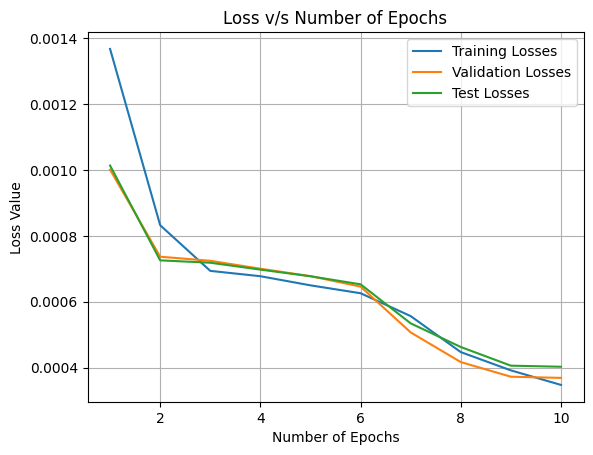

In [525]:
plot_loss(training_losses, validation_losses, test_losses)

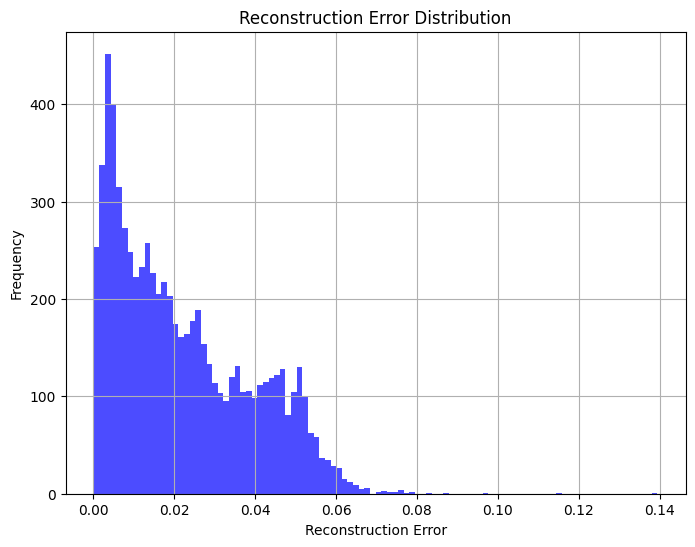

In [526]:
plt.figure(figsize=(8, 6))
plt.hist(train_reconstruction_errors, bins=100, color='blue', alpha=0.7)
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Reconstruction Error Distribution')
plt.grid(True)
plt.show()

In [527]:
mean, std = np.mean(train_reconstruction_errors), np.std(train_reconstruction_errors)

print(f"Mean: {mean}, Standard Deviation: {std}")

Mean: 0.022033309563994408, Standard Deviation: 0.016833454370498657


In [528]:
# Accounting for 95% of data
anomaly_cutoff = mean + (2 * std)
anomaly_cutoff

0.05570021830499172

In [529]:
train_anomalies_detected = X_train[train_reconstruction_errors > anomaly_cutoff]

In [530]:
train_anomalies_detected

,value,Day,DayOfWeek,Hour,Minute
13,0.281482,0.000000,0.166667,0.260870,1.0
37,0.704024,0.000000,0.166667,0.782609,1.0
1200,0.670903,0.833333,0.833333,0.000000,0.0
1201,0.620812,0.833333,0.833333,0.000000,1.0
1248,0.654546,0.866667,1.000000,0.000000,0.0
...,...,...,...,...,...
5996,0.442114,0.033333,1.000000,0.956522,0.0
5997,0.393554,0.033333,1.000000,0.956522,1.0
5998,0.330450,0.033333,1.000000,1.000000,0.0
5999,0.260685,0.033333,1.000000,1.000000,1.0


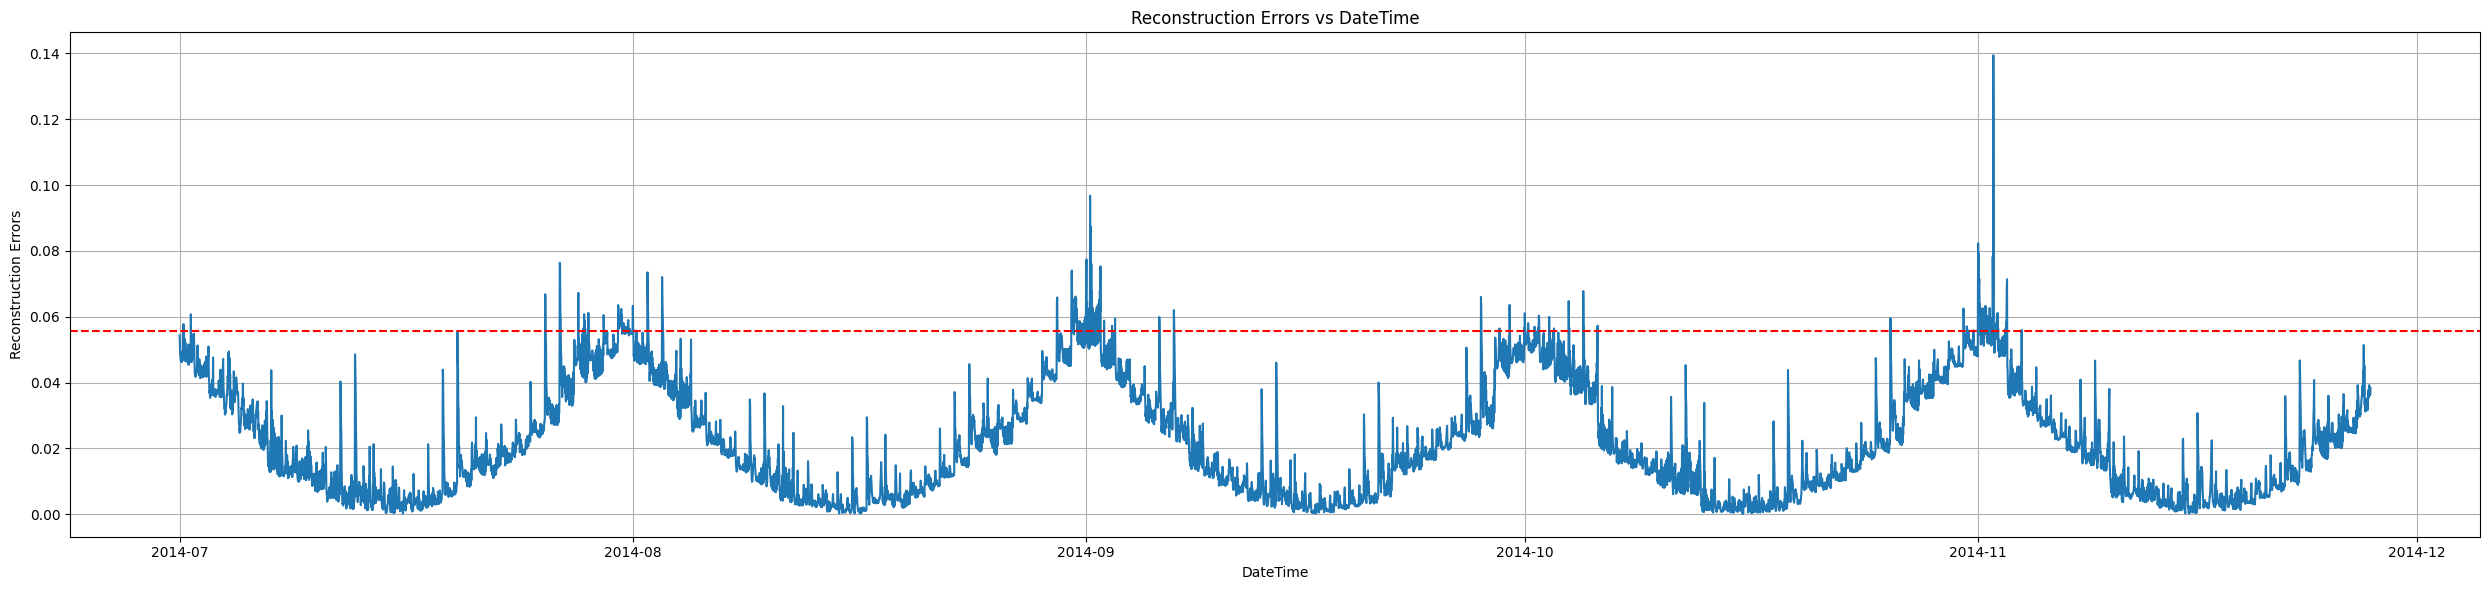

In [531]:
plt.figure(figsize=(25, 6))
plt.plot(df['DateTime'][:7193], train_reconstruction_errors)
plt.axhline(y=anomaly_cutoff, color='red', linestyle='--', label='Anomaly Cutoff')

plt.xlabel('DateTime')
plt.ylabel('Reconstruction Errors')
plt.title('Reconstruction Errors vs DateTime')
plt.grid(True)
plt.tight_layout()
plt.show()

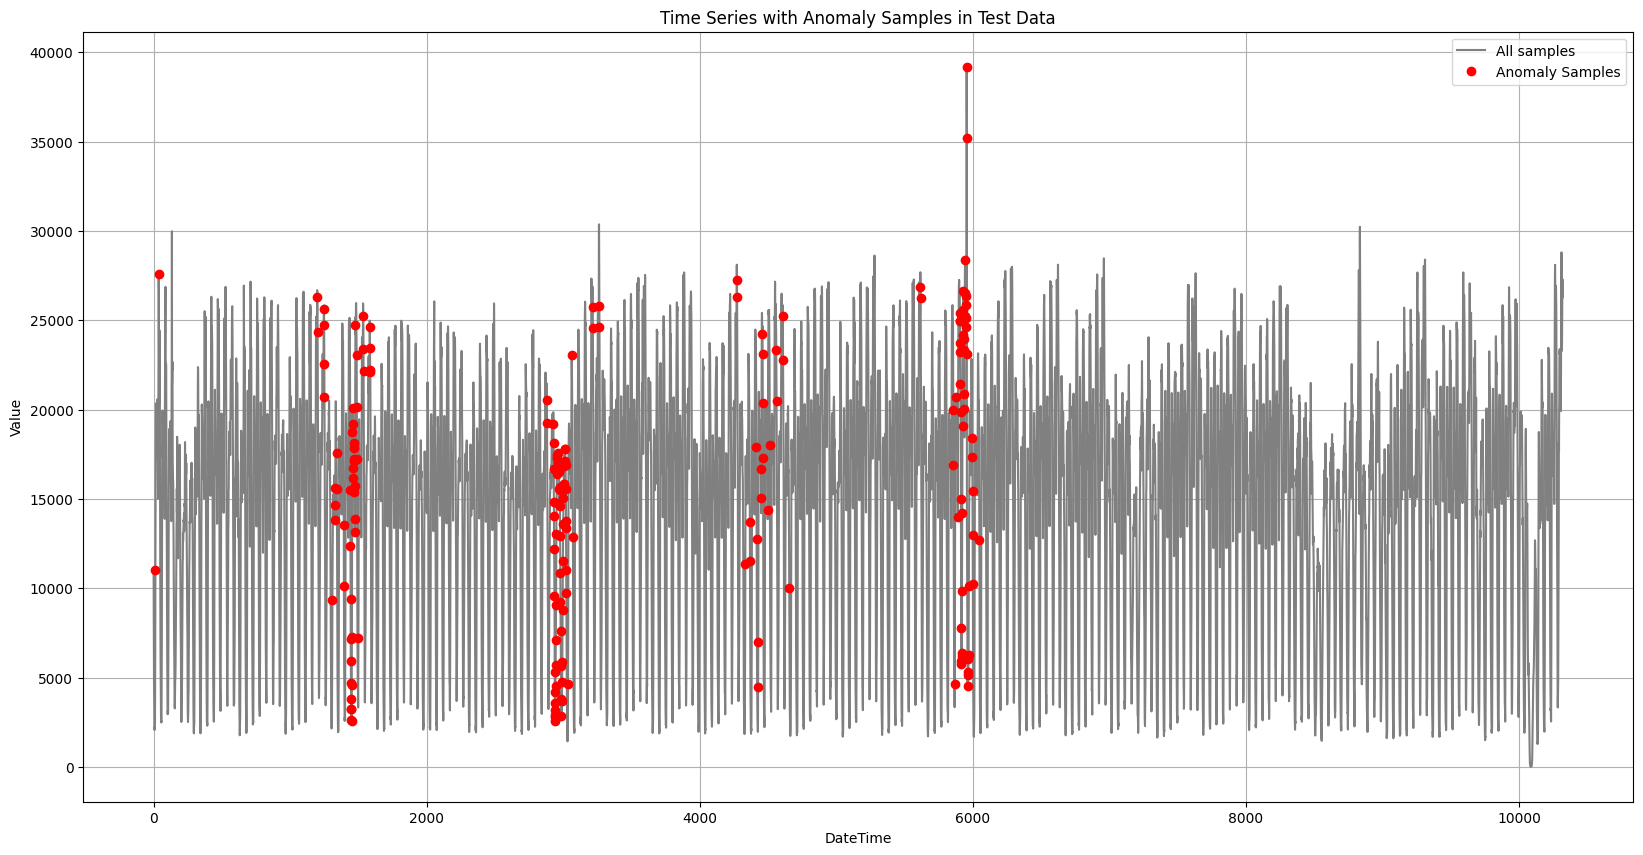

In [532]:
df['value'].plot(figsize=(20, 10), color='gray', label='All samples')
df.loc[train_anomalies_detected.index, 'value'].plot(color='red', label='Anomaly Samples', marker = 'o', linestyle='None')

plt.xlabel('DateTime')
plt.ylabel('Value')
plt.title('Time Series with Anomaly Samples in Train Data')
plt.legend()
plt.grid(True)
plt.show()

In [533]:
anomaly_dates = {}

for i in train_anomalies_detected.index:
    if df.iloc[i]['DateTime'].date() in anomaly_dates:
        anomaly_dates[df.iloc[i]['DateTime'].date()] += 1
    else:
        # print(df.iloc[i]['DateTime'].date())
        anomaly_dates[df.iloc[i]['DateTime'].date()] = 1

In [534]:
anomaly_dates_order = dict(sorted(anomaly_dates.items(), key=lambda k: k[1], reverse=True))
anomaly_dates_order

{datetime.date(2014, 8, 31): 32,
 datetime.date(2014, 11, 1): 32,
 datetime.date(2014, 7, 31): 28,
 datetime.date(2014, 9, 1): 28,
 datetime.date(2014, 11, 2): 15,
 datetime.date(2014, 10, 1): 9,
 datetime.date(2014, 7, 28): 6,
 datetime.date(2014, 10, 31): 5,
 datetime.date(2014, 7, 27): 4,
 datetime.date(2014, 8, 3): 4,
 datetime.date(2014, 8, 1): 3,
 datetime.date(2014, 8, 2): 3,
 datetime.date(2014, 9, 2): 3,
 datetime.date(2014, 9, 29): 3,
 datetime.date(2014, 10, 5): 3,
 datetime.date(2014, 7, 1): 2,
 datetime.date(2014, 7, 26): 2,
 datetime.date(2014, 7, 30): 2,
 datetime.date(2014, 8, 30): 2,
 datetime.date(2014, 9, 6): 2,
 datetime.date(2014, 9, 7): 2,
 datetime.date(2014, 9, 28): 2,
 datetime.date(2014, 10, 4): 2,
 datetime.date(2014, 10, 26): 2,
 datetime.date(2014, 9, 30): 1,
 datetime.date(2014, 10, 2): 1,
 datetime.date(2014, 10, 3): 1,
 datetime.date(2014, 11, 3): 1}

In [535]:
anomalies_detected_test = X_test[test_reconstruction_errors > anomaly_cutoff]

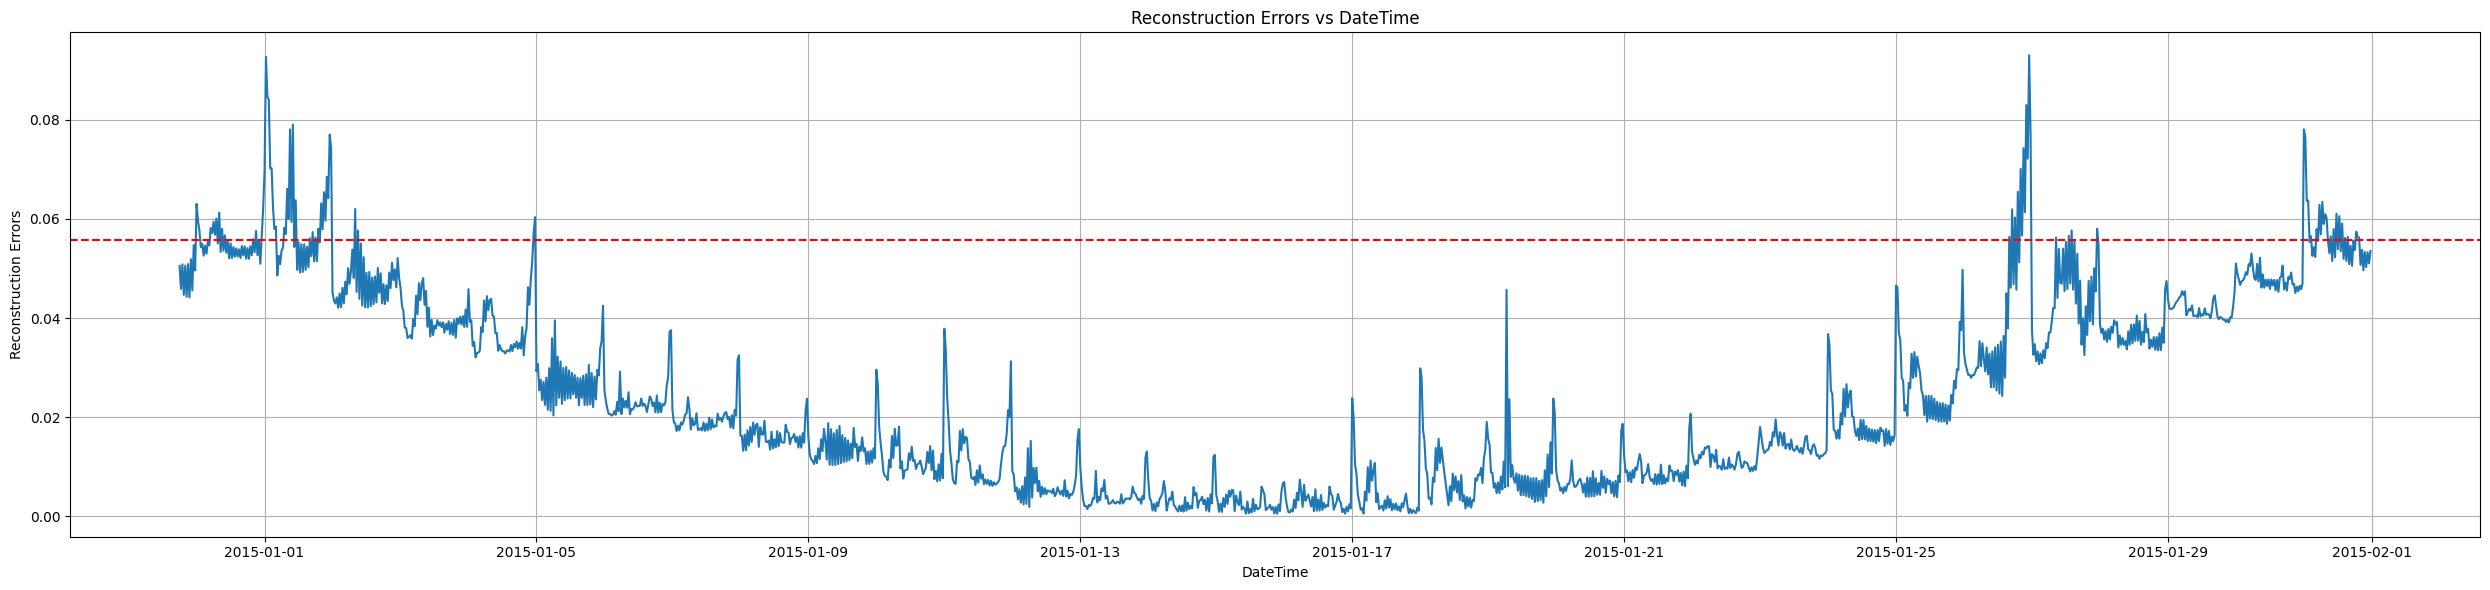

In [536]:
plt.figure(figsize=(25, 6))
plt.plot(df['DateTime'][-1548:], test_reconstruction_errors)
plt.axhline(y=anomaly_cutoff, color='red', linestyle='--', label='Anomaly Cutoff')
plt.xlabel('DateTime')
plt.ylabel('Reconstruction Errors')
plt.title('Reconstruction Errors vs DateTime')
plt.grid(True)
plt.tight_layout()
plt.show()

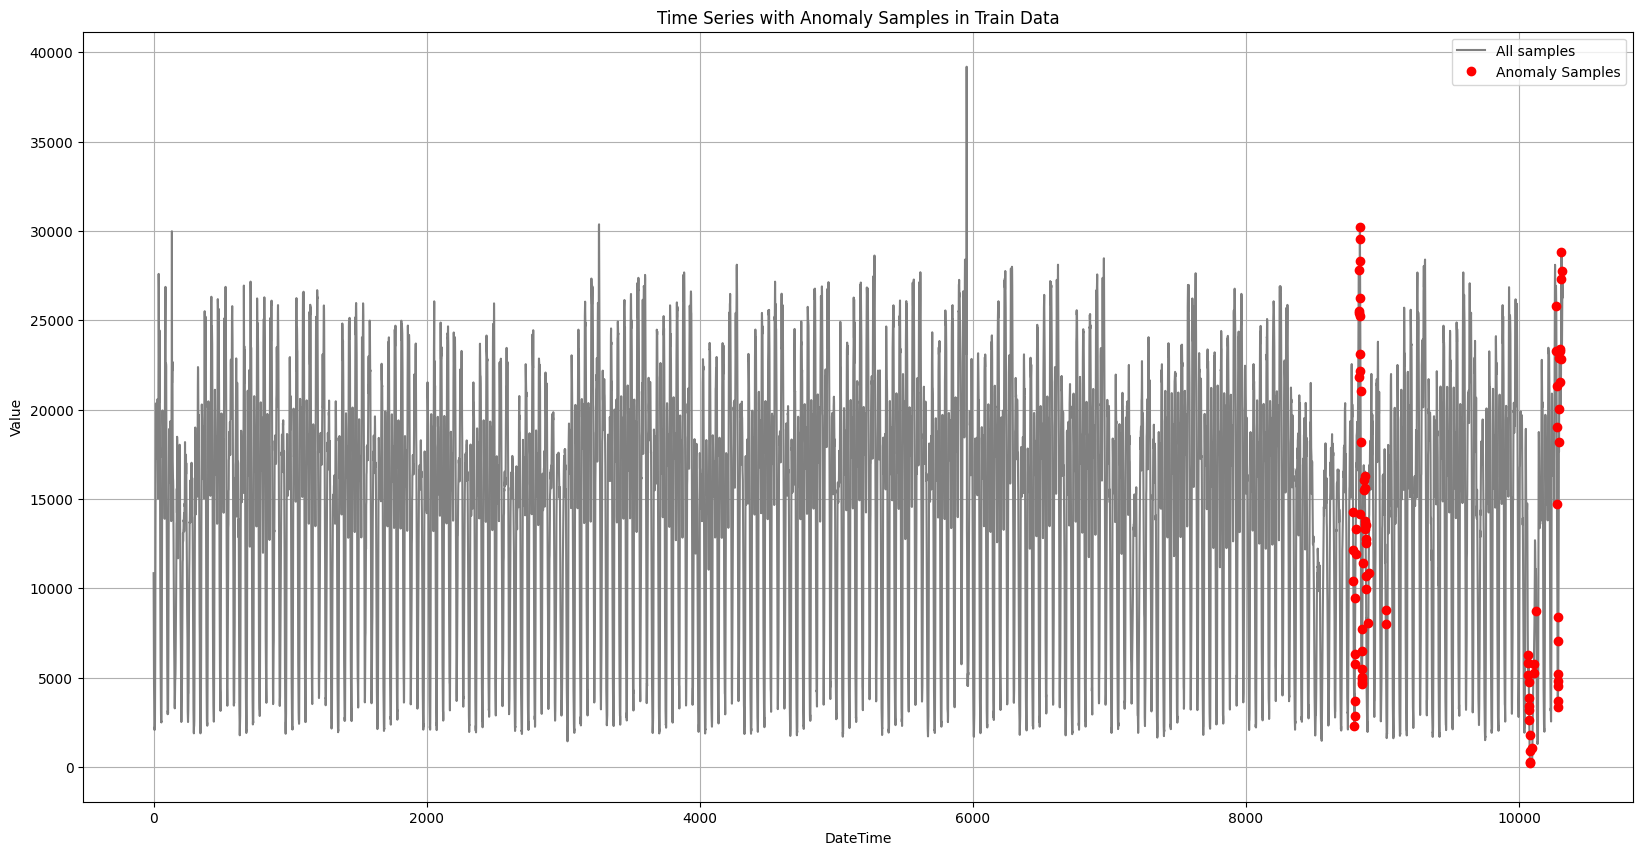

In [537]:
df['value'].plot(x=df['DateTime'], figsize=(20, 10), color='gray', label='All samples')
df.loc[anomalies_detected_test.index, 'value'].plot(color='red', label='Anomaly Samples', marker = 'o',  linestyle='None')

plt.xlabel('DateTime')
plt.ylabel('Value')
plt.title('Time Series with Anomaly Samples in Test Data')
plt.legend()
plt.grid(True)
plt.show()

In [538]:
anomaly_dates_test = {}

for i in anomalies_detected_test.index:
    if df.iloc[i]['DateTime'].date() in anomaly_dates_test:
        anomaly_dates_test[df.iloc[i]['DateTime'].date()] += 1
    else:
        # print(df.iloc[i]['DateTime'].date())
        anomaly_dates_test[df.iloc[i]['DateTime'].date()] = 1

In [539]:
anomaly_dates_order = dict(sorted(anomaly_dates_test.items(), key=lambda k: k[1], reverse=True))
anomaly_dates_order

{datetime.date(2015, 1, 1): 29,
 datetime.date(2015, 1, 31): 22,
 datetime.date(2014, 12, 31): 16,
 datetime.date(2015, 1, 26): 12,
 datetime.date(2015, 1, 27): 4,
 datetime.date(2015, 1, 2): 2,
 datetime.date(2015, 1, 4): 2}

### **Architecture 3**

In [561]:
class AutoEncoderLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(AutoEncoderLSTM, self).__init__()
        self.encoder_lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.decoder_lstm = nn.LSTM(hidden_dim, input_dim, batch_first=True)
        self.activation = nn.ReLU()

    def forward(self, x):
        _, (h_enc, c_enc) = self.encoder_lstm(x)
        x_pred, _ = self.decoder_lstm(h_enc)
        return x_pred

In [562]:
model_lstm = AutoEncoderLSTM(input_dim = X_train.shape[1], hidden_dim = 2)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_lstm.parameters(), lr=0.001)

In [563]:
print(model_lstm)
print(summary(model_lstm, input_size=X_train.shape))

AutoEncoderLSTM(
  (encoder_lstm): LSTM(5, 2, batch_first=True)
  (decoder_lstm): LSTM(2, 5, batch_first=True)
  (activation): ReLU()
)
Layer (type:depth-idx)                   Output Shape              Param #
AutoEncoderLSTM                          [1, 5]                    --
├─LSTM: 1-1                              [7193, 2]                 72
├─LSTM: 1-2                              [1, 5]                    180
Total params: 252
Trainable params: 252
Non-trainable params: 0
Total mult-adds (M): 1.04
Input size (MB): 0.14
Forward/backward pass size (MB): 0.12
Params size (MB): 0.00
Estimated Total Size (MB): 0.26


In [564]:
training_losses, validation_losses, test_losses = [], [], []
num_epochs = 10

for epoch in range(num_epochs):
    model_lstm.train()
    train_loss = 0.0
    train_reconstruction_errors = []
    criterion = nn.MSELoss()
    for inputs in train_loader:
        optimizer.zero_grad()
        inputs = inputs.float()
        outputs = model_lstm(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_reconstruction_errors.extend(torch.mean((outputs - inputs)**2, dim=1).detach().numpy())
    train_loss /= len(train_loader.dataset)
    training_losses.append(train_loss)

    # Validation
    model_lstm.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs in val_loader:
            inputs = inputs.float()
            outputs = model_lstm(inputs)
            val_loss += criterion(outputs, inputs).item()
    val_loss /= len(val_loader.dataset)
    validation_losses.append(val_loss)

    test_reconstruction_errors = []
    model_lstm.eval()
    test_loss = 0.0
    # criterion = nn.MSELoss(reduction='none')
    with torch.no_grad():
        for inputs in test_loader:
            inputs = inputs.float()
            outputs = model_lstm(inputs)
            test_loss += criterion(outputs, inputs).item()
            test_reconstruction_errors.extend(torch.mean((outputs - inputs)**2, dim=1).detach().numpy())

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}, Test Loss: {test_loss}')

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64, 5])) that is different to the input size (torch.Size([1, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([25, 5])) that is different to the input size (torch.Size([1, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([43, 5])) that is different to the input size (torch.Size([1, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(

Epoch 1/10, Train Loss: 0.0051270206908796525, Validation Loss: 0.004770992865209114, Test Loss: 0.004991319097905812
Epoch 2/10, Train Loss: 0.003954097752890633, Validation Loss: 0.0036061280103255253, Test Loss: 0.0037687002929067117
Epoch 3/10, Train Loss: 0.002902486021688083, Validation Loss: 0.0026241455267244232, Test Loss: 0.0027347112252576714
Epoch 4/10, Train Loss: 0.002180073891406296, Validation Loss: 0.0021043597160826156, Test Loss: 0.0021794841790846154
Epoch 5/10, Train Loss: 0.001896614456117095, Validation Loss: 0.0019327472893024562, Test Loss: 0.001991594691570723
Epoch 6/10, Train Loss: 0.0018108314480417614, Validation Loss: 0.0018765346971095704, Test Loss: 0.0019274301326398086
Epoch 7/10, Train Loss: 0.0017840581300376968, Validation Loss: 0.001855384140848132, Test Loss: 0.0019020577579813719
Epoch 8/10, Train Loss: 0.0017746237114260363, Validation Loss: 0.0018457264189406088, Test Loss: 0.0018901032677223516
Epoch 9/10, Train Loss: 0.001770098044604465, Va

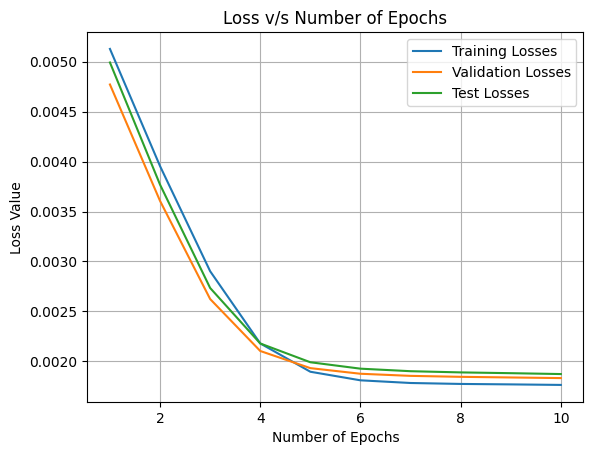

In [565]:
plot_loss(training_losses, validation_losses, test_losses)

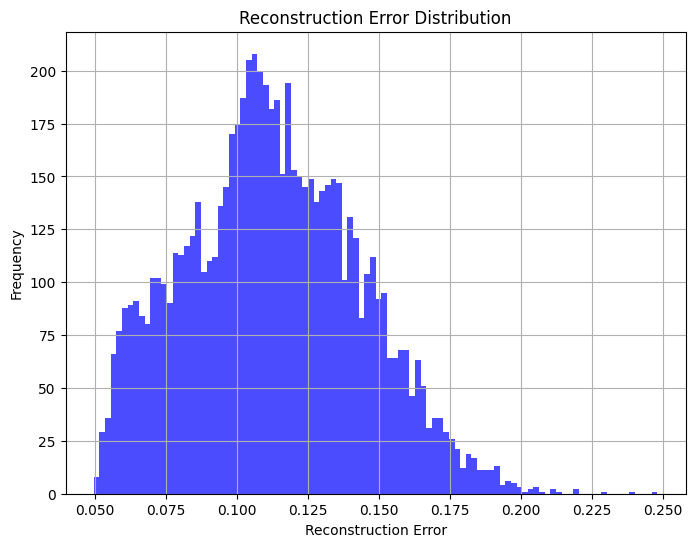

In [566]:
plt.figure(figsize=(8, 6))
plt.hist(train_reconstruction_errors, bins=100, color='blue', alpha=0.7)
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Reconstruction Error Distribution')
plt.grid(True)
plt.show()

In [567]:
mean, std = np.mean(train_reconstruction_errors), np.std(train_reconstruction_errors)

print(f"Mean: {mean}, Standard Deviation: {std}")

Mean: 0.11246512830257416, Standard Deviation: 0.03075864166021347


In [568]:
# Accounting for 95% of data
anomaly_cutoff = mean + (2 * std)
anomaly_cutoff

0.1739824116230011

In [569]:
train_anomalies_detected = X_train[train_reconstruction_errors > anomaly_cutoff]
train_anomalies_detected

,value,Day,DayOfWeek,Hour,Minute
286,0.336574,0.166667,1.0,1.000000,0.0
287,0.289546,0.166667,1.0,1.000000,1.0
1248,0.654546,0.866667,1.0,0.000000,0.0
1249,0.631300,0.866667,1.0,0.000000,1.0
1250,0.575263,0.866667,1.0,0.043478,0.0
...,...,...,...,...,...
6046,0.371176,0.066667,0.0,1.000000,0.0
6047,0.323739,0.066667,0.0,1.000000,1.0
6288,0.687004,0.266667,1.0,0.000000,0.0
6960,0.699584,0.733333,1.0,0.000000,0.0


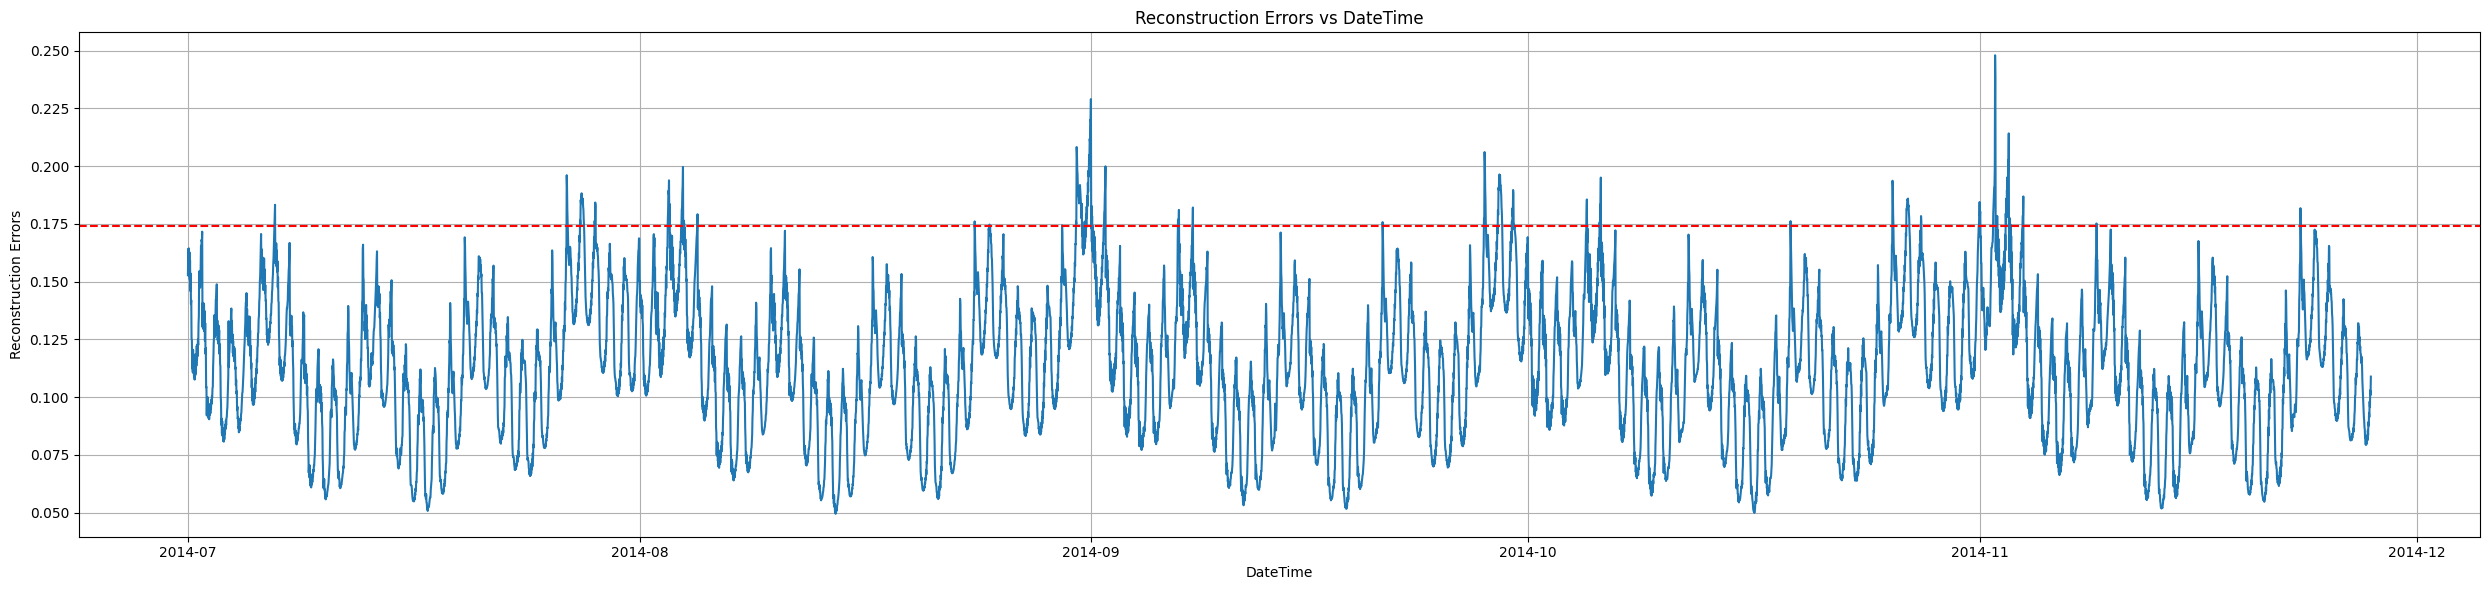

In [570]:
plt.figure(figsize=(25, 6))
plt.plot(df['DateTime'][:7193], train_reconstruction_errors)
plt.axhline(y=anomaly_cutoff, color='red', linestyle='--', label='Anomaly Cutoff')

plt.xlabel('DateTime')
plt.ylabel('Reconstruction Errors')
plt.title('Reconstruction Errors vs DateTime')
plt.grid(True)
plt.tight_layout()
plt.show()

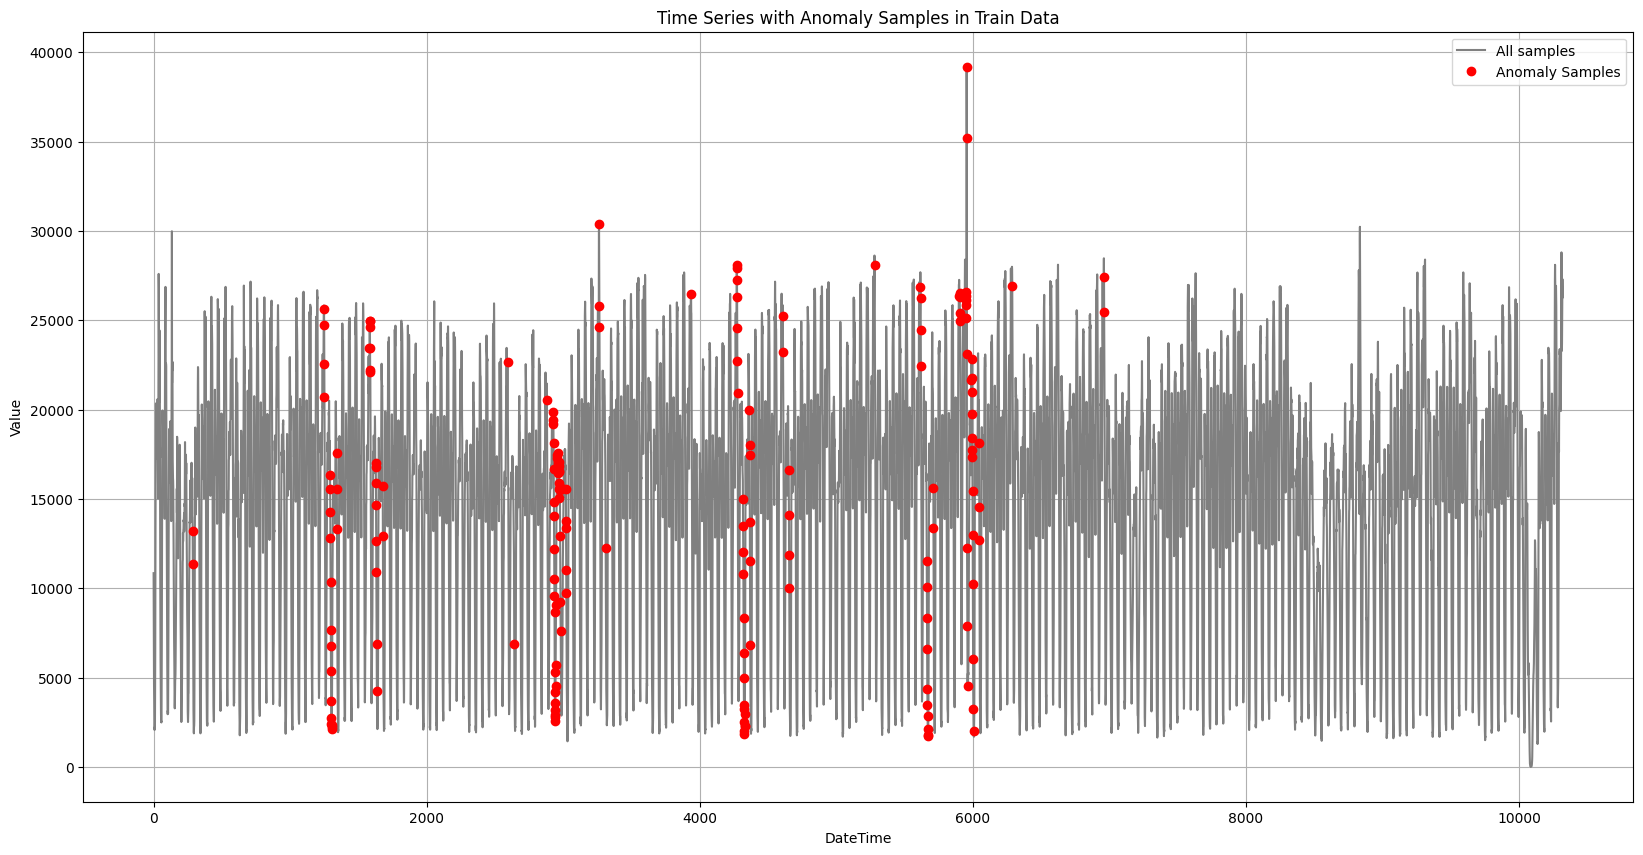

In [571]:
df['value'].plot(figsize=(20, 10), color='gray', label='All samples')
df.loc[train_anomalies_detected.index, 'value'].plot(color='red', label='Anomaly Samples', marker = 'o', linestyle='None')

plt.xlabel('DateTime')
plt.ylabel('Value')
plt.title('Time Series with Anomaly Samples in Train Data')
plt.legend()
plt.grid(True)
plt.show()

In [572]:
anomaly_dates = {}

for i in train_anomalies_detected.index:
    if df.iloc[i]['DateTime'].date() in anomaly_dates:
        anomaly_dates[df.iloc[i]['DateTime'].date()] += 1
    else:
        # print(df.iloc[i]['DateTime'].date())
        anomaly_dates[df.iloc[i]['DateTime'].date()] = 1

In [573]:
anomaly_dates_order = dict(sorted(anomaly_dates.items(), key=lambda k: k[1], reverse=True))
anomaly_dates_order

{datetime.date(2014, 8, 31): 37,
 datetime.date(2014, 11, 2): 18,
 datetime.date(2014, 9, 29): 16,
 datetime.date(2014, 7, 28): 13,
 datetime.date(2014, 8, 3): 10,
 datetime.date(2014, 10, 27): 10,
 datetime.date(2014, 9, 28): 9,
 datetime.date(2014, 7, 27): 8,
 datetime.date(2014, 9, 1): 8,
 datetime.date(2014, 10, 5): 6,
 datetime.date(2014, 10, 26): 6,
 datetime.date(2014, 11, 1): 6,
 datetime.date(2014, 11, 3): 6,
 datetime.date(2014, 8, 4): 4,
 datetime.date(2014, 8, 2): 3,
 datetime.date(2014, 8, 30): 3,
 datetime.date(2014, 9, 7): 3,
 datetime.date(2014, 10, 31): 3,
 datetime.date(2014, 7, 6): 2,
 datetime.date(2014, 9, 27): 2,
 datetime.date(2014, 11, 23): 2,
 datetime.date(2014, 8, 24): 1,
 datetime.date(2014, 8, 25): 1,
 datetime.date(2014, 9, 6): 1,
 datetime.date(2014, 9, 21): 1,
 datetime.date(2014, 9, 30): 1,
 datetime.date(2014, 10, 19): 1,
 datetime.date(2014, 11, 9): 1}

In [574]:
anomalies_detected_test = X_test[test_reconstruction_errors > anomaly_cutoff]

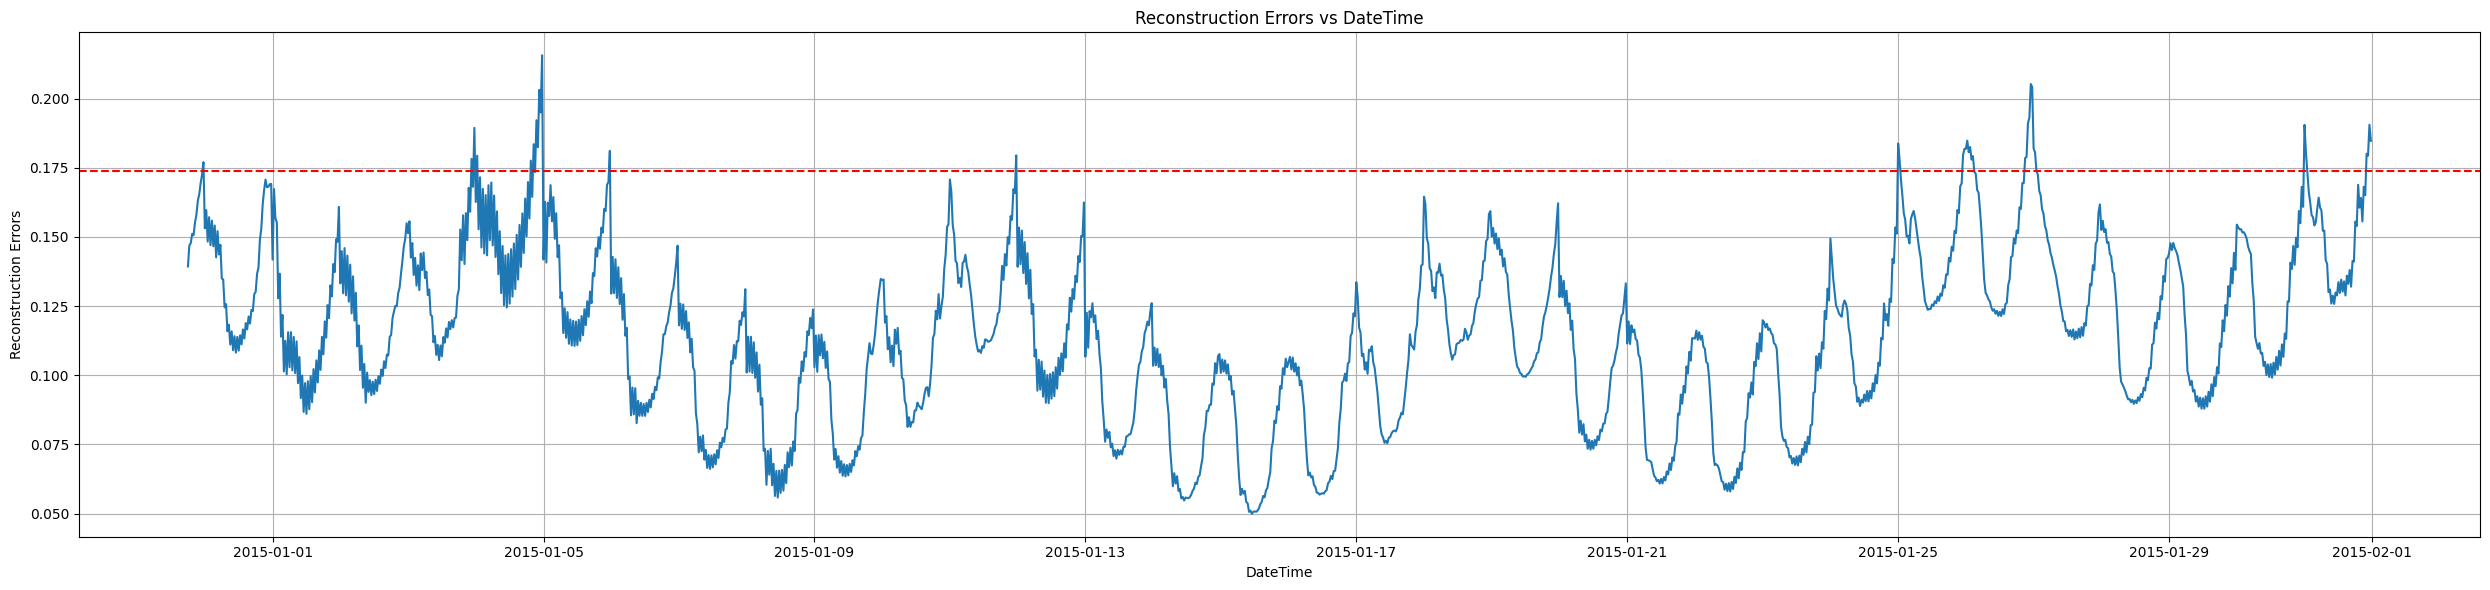

In [575]:
plt.figure(figsize=(25, 6))
plt.plot(df['DateTime'][-1548:], test_reconstruction_errors)
plt.axhline(y=anomaly_cutoff, color='red', linestyle='--', label='Anomaly Cutoff')
plt.xlabel('DateTime')
plt.ylabel('Reconstruction Errors')
plt.title('Reconstruction Errors vs DateTime')
plt.grid(True)
plt.tight_layout()
plt.show()

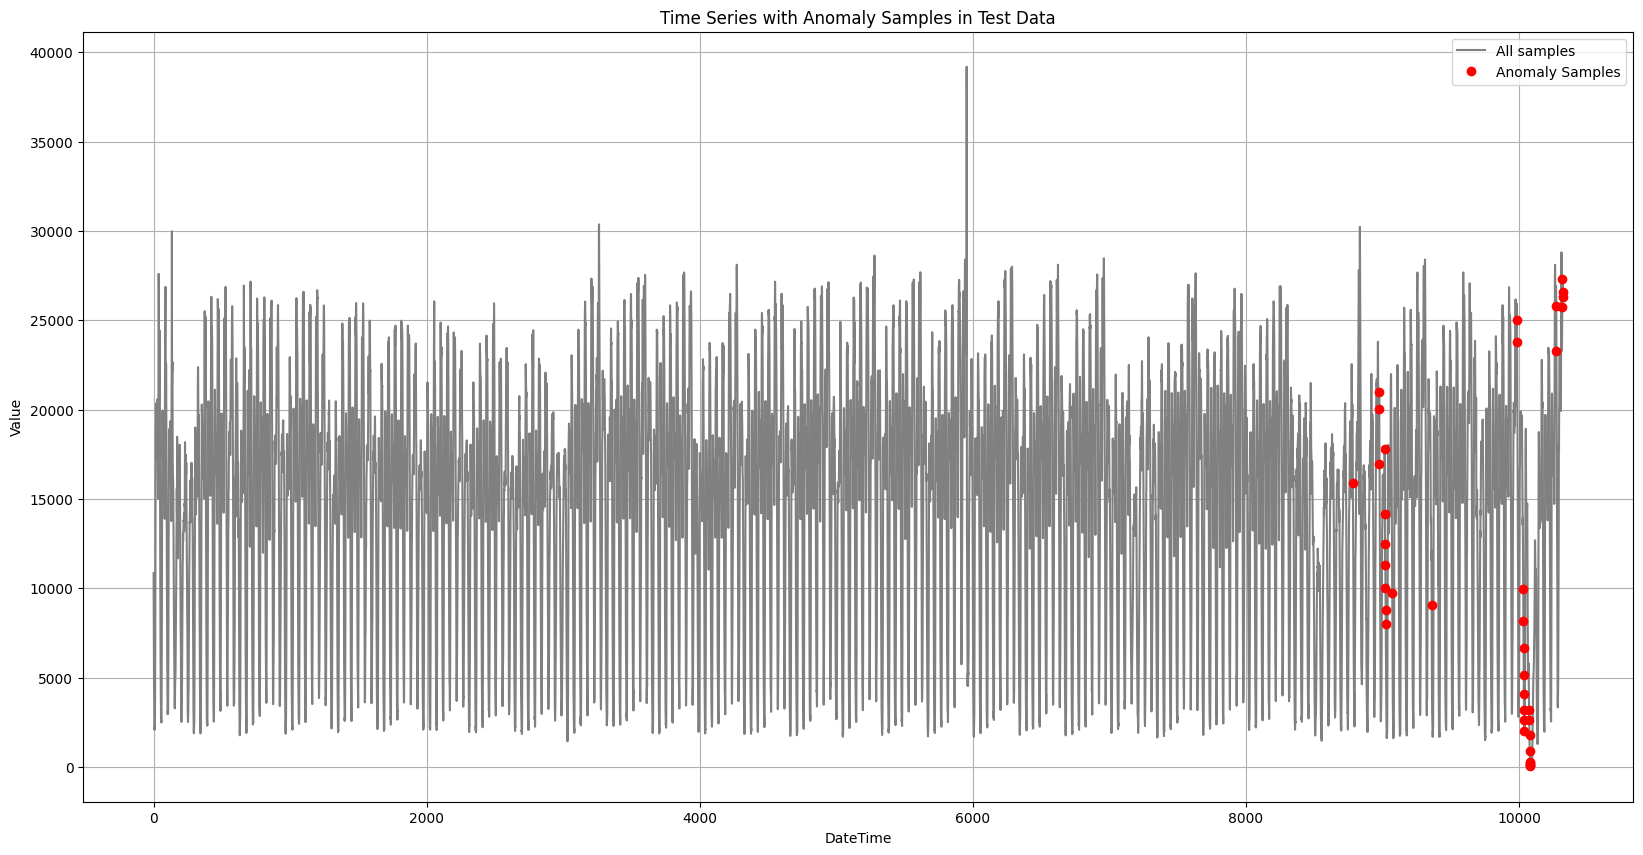

In [576]:
df['value'].plot(x=df['DateTime'], figsize=(20, 10), color='gray', label='All samples')
df.loc[anomalies_detected_test.index, 'value'].plot(color='red', label='Anomaly Samples', marker = 'o',  linestyle='None')

plt.xlabel('DateTime')
plt.ylabel('Value')
plt.title('Time Series with Anomaly Samples in Test Data')
plt.legend()
plt.grid(True)
plt.show()

In [577]:
anomaly_dates_test = {}

for i in anomalies_detected_test.index:
    if df.iloc[i]['DateTime'].date() in anomaly_dates_test:
        anomaly_dates_test[df.iloc[i]['DateTime'].date()] += 1
    else:
        # print(df.iloc[i]['DateTime'].date())
        anomaly_dates_test[df.iloc[i]['DateTime'].date()] = 1

In [578]:
anomaly_dates_order = dict(sorted(anomaly_dates_test.items(), key=lambda k: k[1], reverse=True))
anomaly_dates_order

{datetime.date(2015, 1, 26): 12,
 datetime.date(2015, 1, 4): 8,
 datetime.date(2015, 1, 31): 6,
 datetime.date(2015, 1, 25): 4,
 datetime.date(2015, 1, 27): 3,
 datetime.date(2015, 1, 3): 2,
 datetime.date(2014, 12, 30): 1,
 datetime.date(2015, 1, 5): 1,
 datetime.date(2015, 1, 11): 1}

In [581]:
torch.save(model_lstm.state_dict(), './saisavit_ychennu_weights.h5')